# <font color='#197D75'> MD005 - Categorizacion </font>

####
Este trabajo practico tiene su base fundamental en el estudio realizado anteriormente. Partiremos de las mejoras planteadas anteriormente, intentando afinar nuestra estimacion previa con las restricciones observadas. He construido una base de datos en la cual cuento con las estadisticas por jugador en minutos para la temporada 2023-2024, y otra base de datos con las posiciones, dividida en 3 grandes grupos (Guard, Center y Forward). Tal como explicamos anteriormente, el juego en la NBA ha evolucionado, y hoy en dia es dificil poder clasificar a un jugador por su rendimiento ya que "todos hacen todo". El desafio estara en poder ver si con las estadisticas llevadas a minutos jugados, podemos tener mayor claridad con esto, logrando asi un modelo de clasificacion robusto. 

Nuestra base de datos de rendimiento fue obtenida de https://www.nba.com/stats/players/traditional?PerMode=PerMinute&DateFrom=&DateTo=&Season=2023-24, mientras que nuestra base de datos de informacion personal de los jugadores fue obtenida de https://www.nba.com/players.

En primer lugar, intentare lograr una mejora sustancial en la estimacion del clustering del ejercicio anterior. Luego, intentare llevar a cabo tipos de clasificiacion multiclase (KNN y Arboles de decision) donde intentaremos entrenar el modelo para que sea capaz de etiquetar de manera consistente. Veremos que sucede. Por ultimo, planteare una clasificacion binaria para realizar la estimacion a traves de la regresion logistica.

In [1]:
# Importación de librerías para manipulación y visualización de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

# Importación de librerías de sklearn para modelado y evaluación
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from scipy.cluster import hierarchy
import openpyxl
from sklearn.datasets import load_iris
from IPython.display import Image
from six import StringIO
import pydotplus

In [2]:
# Especifica la ruta del archivo CSV
ruta_archivo2 = "C:/Users/Mateo/Documents/Mateo/Data Science - La Salle/MD005 - Sistemas basados en el conocimiento/TP3 - Clasificacion/NBA_basecompleta.xlsx"
ruta_archivo3 = "C:/Users/Mateo/Documents/Mateo/Data Science - La Salle/MD005 - Sistemas basados en el conocimiento/TP3 - Clasificacion/NBA_positions.xlsx"

# Lee el archivo CSV y almacena los datos en un DataFrame de pandas
datos2 = pd.read_excel(ruta_archivo2)
datos3 = pd.read_excel(ruta_archivo3)
datos3.head()

,PLAYER,NUMBER,POSITION,LAST ATTENDED,COUNTRY
0,Precious Achiuwa,5,F,Memphis,Nigeria
1,Steven Adams,4,C,Pittsburgh,New Zealand
2,Bam Adebayo,13,C-F,Kentucky,USA
3,Ochai Agbaji,30,G,Kansas,USA
4,Santi Aldama,7,F-C,Loyola-Maryland,Spain


In [3]:
# Merge de datos2 y datos3
datos_merge = pd.merge(datos2, datos3, on='PLAYER', how='left')

In [4]:
datos_merge.head()

,ID_Player,PLAYER,TEAM,AGE,GP,W,L,MIN,PTS,FGM,...,BLK,PF,FP,DD2,TD3,+/-,NUMBER,POSITION,LAST ATTENDED,COUNTRY
0,1,Jay Huff,DEN,26,2,2,0,1.5,1.31,0.65,...,0.00,0.00,1.31,0.0,0.0,-2.61,30.0,C,Virginia,USA
1,2,Drew Peterson,BOS,24,1,1,0,2.5,1.18,0.39,...,0.00,0.39,1.76,0.0,0.0,0.78,NaN,NaN,NaN,NaN
2,3,Joel Embiid,PHI,29,25,20,5,854.1,1.02,0.34,...,0.06,0.08,1.86,21.0,1.0,0.29,21.0,C-F,Kansas,Cameroon
3,4,Luka Doncic,DAL,24,31,19,12,1145.5,0.90,0.31,...,0.02,0.05,1.61,21.0,6.0,0.05,77.0,F-G,Real Madrid,Slovenia
4,5,Shai Gilgeous-Alexander,OKC,25,30,22,8,1040.8,0.90,0.32,...,0.02,0.07,1.61,3.0,0.0,0.29,2.0,G,Kentucky,Canada


####

Supongamos que tienes un DataFrame llamado `datos_merge` que contiene las siguientes columnas:

- <font color='#197D75'>**GP:**</font> Partidos Jugados
- <font color='#197D75'>**W:**</font> Victorias
- <font color='#197D75'>**L:**</font> Derrotas
- <font color='#197D75'>**MIN:**</font> Minutos Jugados
- <font color='#197D75'>**PTS:**</font> Puntos
- <font color='#197D75'>**FGM:**</font> Tiros de Campo Convertidos
- <font color='#197D75'>**FGA:**</font> Intentos de Tiros de Campo
- <font color='#197D75'>**FG%:**</font> Porcentaje de Tiros de Campo
- <font color='#197D75'>**3PM:**</font> Tiros de 3 Puntos Convertidos
- <font color='#197D75'>**3PA:**</font> Intentos de Tiros de 3 Puntos
- <font color='#197D75'>**3P%:**</font> Porcentaje de Tiros de 3 Puntos
- <font color='#197D75'>**FTM:**</font> Tiros Libres Convertidos
- <font color='#197D75'>**FTA:**</font> Intentos de Tiros Libres
- <font color='#197D75'>**FT%:**</font> Porcentaje de Tiros Libres
- <font color='#197D75'>**OREB:**</font> Rebotes Ofensivos
- <font color='#197D75'>**DREB:**</font> Rebotes Defensivos
- <font color='#197D75'>**REB:**</font> Rebotes Totales
- <font color='#197D75'>**AST:**</font> Asistencias
- <font color='#197D75'>**TOV:**</font> Pérdidas de Balón
- <font color='#197D75'>**STL:**</font> Robos
- <font color='#197D75'>**BLK:**</font> Bloqueos
- <font color='#197D75'>**PF:**</font> Faltas Personales
- <font color='#197D75'>**FP:**</font> Puntos de Fantasía
- <font color='#197D75'>**DD2:**</font> Dobles Dobles
- <font color='#197D75'>**TD3:**</font> Triples Dobles
- <font color='#197D75'>**+/-:**</font> Plus-Minus


In [5]:
datos_merge = datos_merge.dropna()

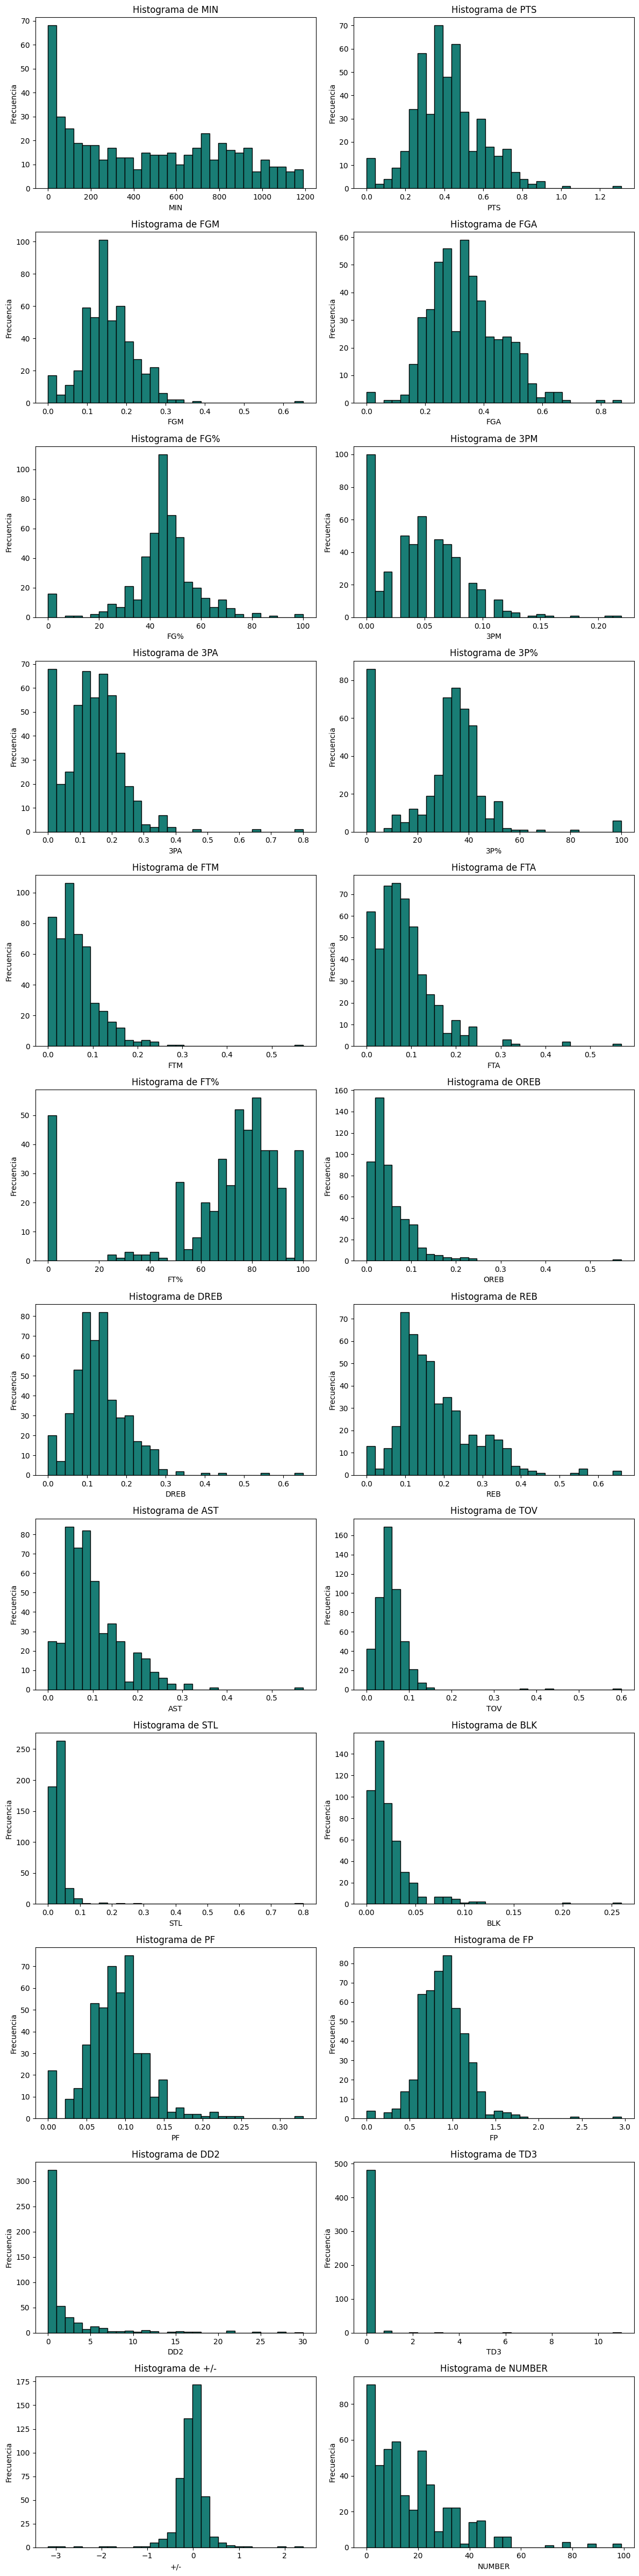

In [6]:
# Filtrar solo las columnas de tipo float
columnas_float = datos_merge.select_dtypes(include=['float64'])

# Definir la disposición de la cuadrícula
num_filas = (len(columnas_float.columns) + 1) // 2
num_columnas = 2

# Crear la cuadrícula de subgráficos
fig, axs = plt.subplots(num_filas, num_columnas, figsize=(12, 4 * num_filas))
fig.subplots_adjust(hspace=0.5)  # Ajustar espacios verticales

# Crear histogramas para cada columna float
for i, columna in enumerate(columnas_float.columns):
    fila = i // num_columnas
    columna_actual = i % num_columnas

    axs[fila, columna_actual].hist(datos_merge[columna], bins=30, edgecolor='black', color='#197D75')
    axs[fila, columna_actual].set_title(f'Histograma de {columna}')
    axs[fila, columna_actual].set_xlabel(columna)
    axs[fila, columna_actual].set_ylabel('Frecuencia')

# Ajustar automáticamente la disposición para evitar superposiciones
plt.tight_layout()

# Mostrar los gráficos
plt.show()


Vamos a plantear un analisis previo para evaluar si nuestra hipotesis inicial se ve reflejada en los casos conocidos, tales como LeBron James y Stephen Curry.

In [7]:
datos_merge['es_lebron'] = (datos_merge['PLAYER'] == 'LeBron James').astype(int)
datos_merge[datos_merge['es_lebron'] == 1]
variables_interes = ["AGE", "GP", "W", "L", "MIN", "PTS", "FGM", "FGA", "FG%", "3PM", "3PA", "3P%", "FTM", "FTA", "FT%",
                     "OREB", "DREB", "REB", "AST", "TOV", "STL", "BLK", "PF", "FP", "DD2", "TD3"]
grupo_es_lebron = datos_merge.groupby('es_lebron')[variables_interes].mean()
print(grupo_es_lebron)


                 AGE         GP          W          L          MIN       PTS  \
es_lebron                                                                      
0          25.789047  20.904665  10.450304  10.454361   470.789047  0.416673   
1          39.000000  31.000000  15.000000  16.000000  1060.000000  0.740000   

                FGM       FGA        FG%       3PM  ...     DREB       REB  \
es_lebron                                           ...                      
0          0.153529  0.340406  45.074239  0.046491  ...  0.13217  0.181014   
1          0.280000  0.520000  53.500000  0.070000  ...  0.19000  0.220000   

                AST       TOV       STL       BLK        PF        FP  \
es_lebron                                                               
0          0.098722  0.052089  0.032414  0.020872  0.088195  0.889533   
1          0.220000  0.100000  0.040000  0.020000  0.030000  1.420000   

                 DD2       TD3  
es_lebron                       
0      

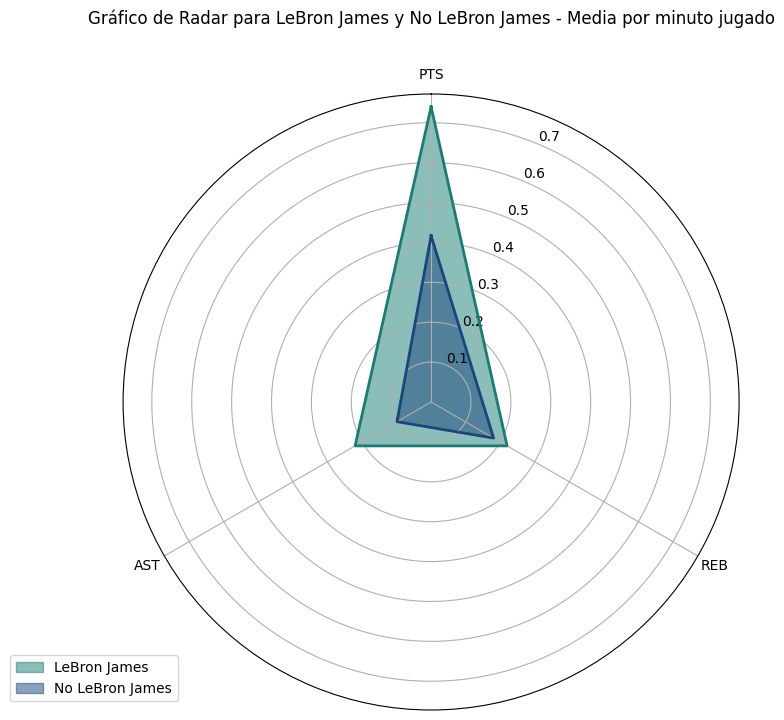

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Variables de interés
variables_interes = ["PTS", "REB", "AST"]

# Datos para LeBron James y No LeBron James
lebron_data = grupo_es_lebron.loc[1, variables_interes].values
no_lebron_data = grupo_es_lebron.loc[0, variables_interes].values

# Número de variables
num_vars = len(variables_interes)

# Ángulos para el gráfico de radar
angulos = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Cerrar el círculo
lebron_data = np.concatenate((lebron_data, [lebron_data[0]]))
no_lebron_data = np.concatenate((no_lebron_data, [no_lebron_data[0]]))
angulos += [angulos[0]]

# Configuración del gráfico de radar
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.fill(angulos, lebron_data, color='#197D75', alpha=0.5, label='LeBron James')
ax.fill(angulos, no_lebron_data, color='#19467D', alpha=0.5, label='No LeBron James')
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Añadir líneas que conectan los puntos
ax.plot(angulos, lebron_data, color='#197D75', linestyle='solid', linewidth=2)
ax.plot(angulos, no_lebron_data, color='#19467D', linestyle='solid', linewidth=2)

# Añadir etiquetas a cada variable
ax.set_xticks(angulos[:-1])
ax.set_xticklabels(variables_interes)

# Ajustar el título del gráfico
ax.set_title('Gráfico de Radar para LeBron James y No LeBron James - Media por minuto jugado', y=1.1)

# Añadir leyenda
ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Mostrar el gráfico
plt.show()


####
Claramente el objetivo inicial que teniamos en el ejercicio anterior era poder identificar con claridad los tipos de jugadores. En este caso aprovechamos el dataset para mostrar la diferencia de media por minuto de puntos, rebotes y asistencias, de todos los jugadores de la NBA comparado con LeBron James. Veamos ahora la diferencia de minutos jugados:

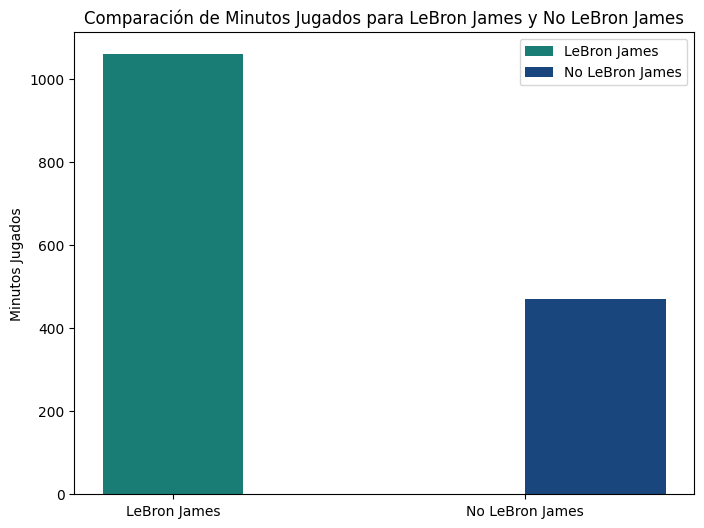

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Variable de interés
variable_interes = "MIN"

# Datos para LeBron James y No LeBron James
minutos_lebron = grupo_es_lebron.loc[1, variable_interes]
minutos_no_lebron = grupo_es_lebron.loc[0, variable_interes]

# Configuración del gráfico de barras
fig, ax = plt.subplots(figsize=(8, 6))
bar_width = 0.4

# Barras para LeBron James
ax.bar("LeBron James", minutos_lebron, color='#197D75', width=bar_width, label='LeBron James')

# Barras para No LeBron James
ax.bar("No LeBron James", minutos_no_lebron, color='#19467D', width=bar_width, label='No LeBron James', align='edge')

# Añadir etiquetas y título
ax.set_ylabel('Minutos Jugados')
ax.set_title('Comparación de Minutos Jugados para LeBron James y No LeBron James')
ax.legend()

# Mostrar el gráfico
plt.show()


No solo tiene mejor score que el promedio de todos los jugadores de la NBA, sino que ademas tiene mucho mas minutos de juego en promedio que todos los jugadores de la NBA. Esto demuestra claramente la clase de jugador que es LeBron James. Hagamos este mismo analisis para Curry:

In [10]:
datos_merge['es_curry'] = (datos_merge['PLAYER'] == 'Stephen Curry').astype(int)
datos_merge[datos_merge['es_curry'] == 1]
variables_interes = ["AGE", "GP", "W", "L", "MIN", "PTS", "FGM", "FGA", "FG%", "3PM", "3PA", "3P%", "FTM", "FTA", "FT%",
                     "OREB", "DREB", "REB", "AST", "TOV", "STL", "BLK", "PF", "FP", "DD2", "TD3"]
grupo_es_curry = datos_merge.groupby('es_curry')[variables_interes].mean()
print(grupo_es_curry)


               AGE         GP          W          L          MIN       PTS  \
es_curry                                                                     
0         25.79716  20.906694  10.450304  10.456389   470.900811  0.416511   
1         35.00000  30.000000  15.000000  15.000000  1004.900000  0.820000   

              FGM       FGA        FG%       3PM  ...      DREB       REB  \
es_curry                                          ...                       
0         0.15357  0.340304  45.090872  0.046349  ...  0.132312  0.181197   
1         0.26000  0.570000  45.300000  0.140000  ...  0.120000  0.130000   

               AST      TOV       STL       BLK        PF       FP       DD2  \
es_curry                                                                       
0         0.098884  0.05211  0.032454  0.020892  0.088154  0.89002  1.770791   
1         0.140000  0.09000  0.020000  0.010000  0.050000  1.18000  2.000000   

               TD3  
es_curry            
0         0.075

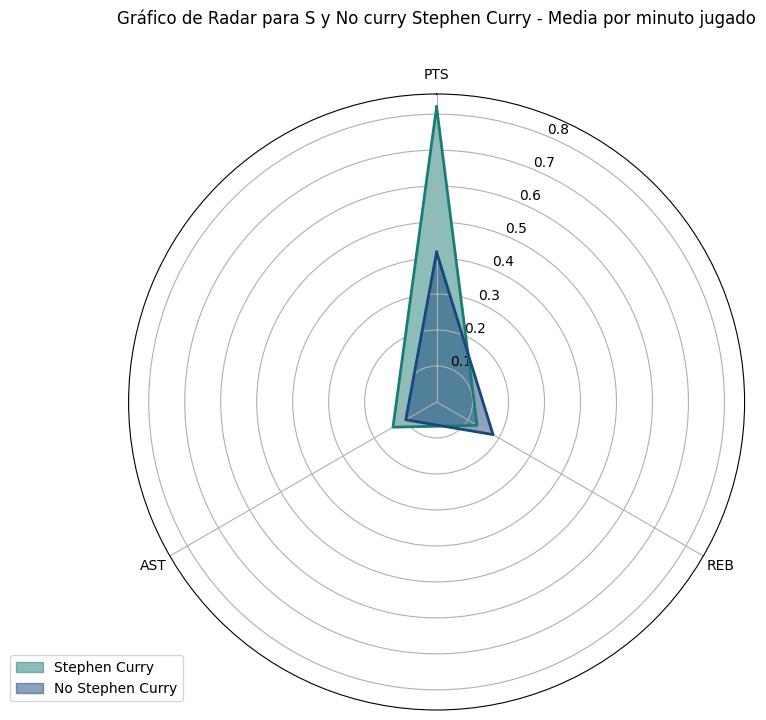

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Variables de interés
variables_interes = ["PTS", "REB", "AST"]

# Datos para curry Stephen Curry y No curry Stephen Curry
curry_data = grupo_es_curry.loc[1, variables_interes].values
no_curry_data = grupo_es_curry.loc[0, variables_interes].values

# Número de variables
num_vars = len(variables_interes)

# Ángulos para el gráfico de radar
angulos = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Cerrar el círculo
curry_data = np.concatenate((curry_data, [curry_data[0]]))
no_curry_data = np.concatenate((no_curry_data, [no_curry_data[0]]))
angulos += [angulos[0]]

# Configuración del gráfico de radar
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.fill(angulos, curry_data, color='#197D75', alpha=0.5, label='Stephen Curry')
ax.fill(angulos, no_curry_data, color='#19467D', alpha=0.5, label='No Stephen Curry')
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Añadir líneas que conectan los puntos
ax.plot(angulos, curry_data, color='#197D75', linestyle='solid', linewidth=2)
ax.plot(angulos, no_curry_data, color='#19467D', linestyle='solid', linewidth=2)

# Añadir etiquetas a cada variable
ax.set_xticks(angulos[:-1])
ax.set_xticklabels(variables_interes)

# Ajustar el título del gráfico
ax.set_title('Gráfico de Radar para S y No curry Stephen Curry - Media por minuto jugado', y=1.1)

# Añadir leyenda
ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Mostrar el gráfico
plt.show()

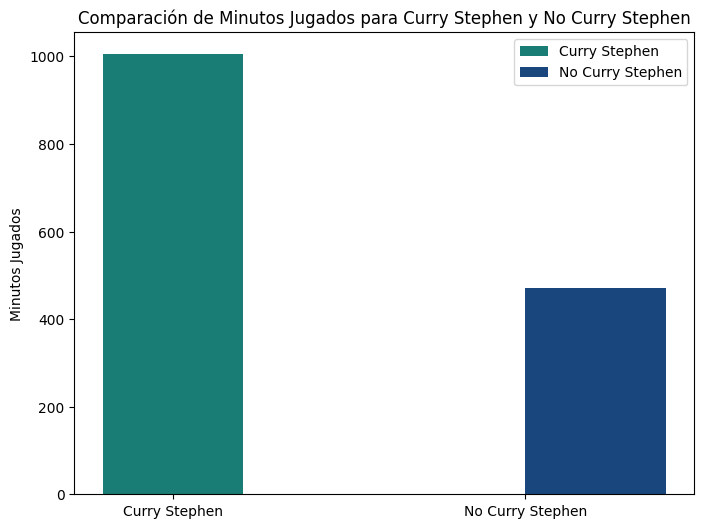

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Variable de interés
variable_interes = "MIN"

# Datos para Curry Stephen y No Curry Stephen
minutos_Curry = grupo_es_curry.loc[1, variable_interes]
minutos_no_Curry = grupo_es_curry.loc[0, variable_interes]

# Configuración del gráfico de barras
fig, ax = plt.subplots(figsize=(8, 6))
bar_width = 0.4

# Barras para Curry Stephen
ax.bar("Curry Stephen", minutos_Curry, color='#197D75', width=bar_width, label='Curry Stephen')

# Barras para No Curry Stephen
ax.bar("No Curry Stephen", minutos_no_Curry, color='#19467D', width=bar_width, label='No Curry Stephen', align='edge')

# Añadir etiquetas y título
ax.set_ylabel('Minutos Jugados')
ax.set_title('Comparación de Minutos Jugados para Curry Stephen y No Curry Stephen')
ax.legend()

# Mostrar el gráfico
plt.show()


En este caso sucede lo mismo que con LeBron James, pero vemos como Curry no posee mas rebotes que el promedio del resto de jugadores de la NBA. Igualmente, vemos su extraordinario desempenio en puntos. Tambien al igual que LeBron, cuenta en promedio con mas minutos jugados que el resto de jugadores de la NBA, y con un promedio por minuto mucho mas alto que los demas. Nuevamente, estamos frente a otro jugador estrella de la NBA. Claramente tenemos un buen foco en nuestra intencion de categorizar jugadores. Ahora bien, para lograr esto debemos tener una base de datos que cuente con una buena separabilidad de los grupos.

### <font color='#197D75'> 1. Clusterizacion sin etiquetas </font>

Volviendo al ejercicio del trabajo anterior, intentaremos ver si afinando nuestra categorizacion sin etiquetas podemos obtener mejores resultados. 

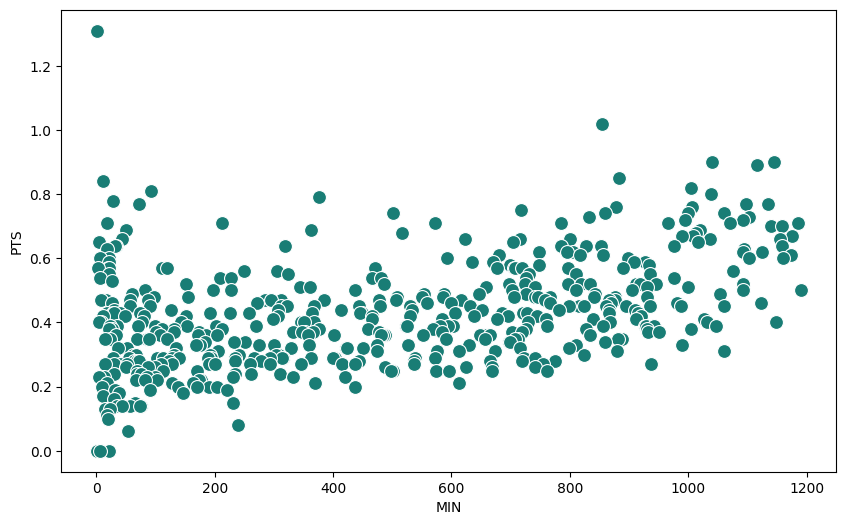

In [13]:
plt.figure(figsize = (10, 6))
sns.scatterplot(data = datos_merge, x = "MIN", y = "PTS", s = 100, color='#197D75')
plt.show()

Aparenta existir una separabilidad mucho mas clara cuando observamos las metricas segun los minutos jugados. Veremos que sucede a la hora de clusterizar sin etiquetas (retomando el objetivo de nuestro trabajo anterior).

In [14]:
columnas_a_normalizar = ['PTS', 'REB', 'AST']

In [15]:
# Separar las variables de entrada
X = datos_merge[columnas_a_normalizar]

# Inicializar el objeto StandardScaler
scaler = StandardScaler()

# Aplicar la estandarización
X_scaled = scaler.fit_transform(X)

# Crear un nuevo DataFrame con las variables normalizadas
subset_final_normalizado = pd.DataFrame(X_scaled, columns=columnas_a_normalizar)

# Agregar la columna 'player_name' al DataFrame normalizado
#season_5_normalized['player_name'] = season_5['player_name']

# Verificar el DataFrame normalizado
print(subset_final_normalizado)

          PTS       REB       AST
0    5.067940 -1.825022 -1.495377
1    3.421532  1.601434  1.224380
2    2.740260  0.492874  2.282063
3    2.740260 -0.212572  1.224380
4    2.683487  1.399877  0.922185
..        ...       ...       ...
489 -2.369283 -1.825022 -1.495377
490 -2.369283 -1.825022 -1.495377
491 -2.369283  0.492874  0.619990
492 -2.369283 -1.825022 -1.495377
493 -2.369283 -1.825022  1.073282

[494 rows x 3 columns]


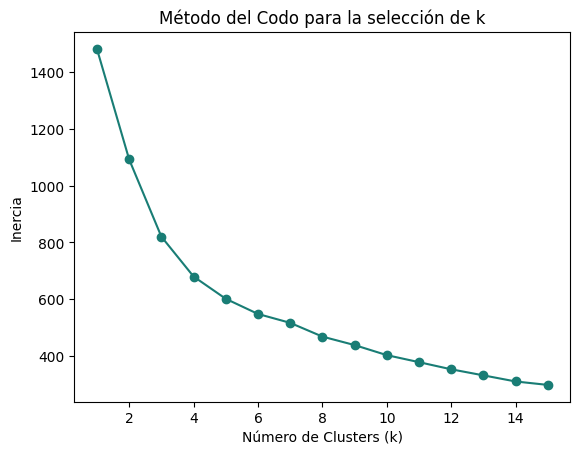

In [16]:
X_data = subset_final_normalizado[['PTS', 'REB', 'AST']].values

# Generar 'k' modelos KMeans
k_values = range(1, 16)
inertias = []

for k in k_values:
    kmeans_model = KMeans(n_clusters=k, random_state=1, n_init=10)
    kmeans_model.fit(X_data)
    inertias.append(kmeans_model.inertia_)

# Graficar la inercia en funcion de k
plt.plot(k_values, inertias, 'o-', color='#197D75')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para la selección de k')
plt.show()

In [17]:
# Función para calcular la derivada primera
def calcular_derivada_primera(k):
    kmeans_model = KMeans(n_clusters=k, random_state=1, n_init=10)
    kmeans_model.fit(X_data)
    return kmeans_model.inertia_

# Generar 'k' modelos KMeans
k_values = range(1, 16)
inertias = []

# Calcular la inercia
for k in k_values:
    kmeans_model = KMeans(n_clusters=k, random_state=1, n_init=10)
    kmeans_model.fit(X_data)
    inertias.append(kmeans_model.inertia_)

# Calcular la derivada primera
derivada_primera = [((inertias[i] - inertias[i-1]) / (k_values[i] - k_values[i-1])) if i > 0 else 0 for i in range(len(inertias))]

# Calcular la variación (delta) para la derivada primera
delta = pd.Series(derivada_primera).diff()

# Crear un DataFrame con los valores de k, la inercia, la derivada primera y la variación (delta)
df_resultados = pd.DataFrame({
    'k_values': list(k_values),
    'inercia': inertias,
    'derivada_primera': derivada_primera,
    'delta': delta
})

# Mostrar el DataFrame
print(df_resultados)


    k_values      inercia  derivada_primera       delta
0          1  1482.000000          0.000000         NaN
1          2  1092.358196       -389.641804 -389.641804
2          3   820.129216       -272.228980  117.412824
3          4   679.528700       -140.600515  131.628465
4          5   600.936262        -78.592439   62.008077
5          6   547.520425        -53.415836   25.176602
6          7   516.148009        -31.372416   22.043420
7          8   467.683000        -48.465009  -17.092593
8          9   437.795965        -29.887034   18.577975
9         10   402.313612        -35.482353   -5.595319
10        11   377.549726        -24.763886   10.718467
11        12   352.351498        -25.198227   -0.434341
12        13   330.974967        -21.376532    3.821695
13        14   309.458105        -21.516861   -0.140329
14        15   297.313762        -12.144344    9.372517


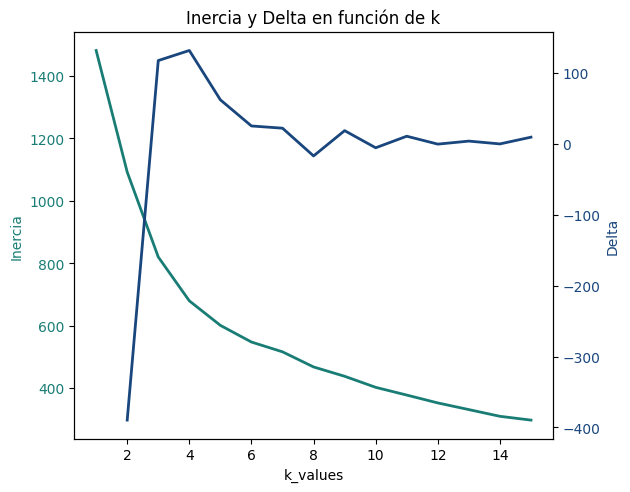

In [18]:
# Crear una figura y ejes
fig, ax1 = plt.subplots()

# Graficar la inercia en el eje izquierdo
color_inercia = '#197D75'  # Color para inercia
ax1.set_xlabel('k_values')
ax1.set_ylabel('Inercia', color=color_inercia)
ax1.plot(df_resultados['k_values'], df_resultados['inercia'], color=color_inercia, label='Inercia', linewidth=2)
ax1.tick_params(axis='y', labelcolor=color_inercia)

# Crear un segundo eje para delta en el eje derecho
ax2 = ax1.twinx()
color_delta = '#19467D'  # Color para delta
ax2.set_ylabel('Delta', color=color_delta)
ax2.plot(df_resultados['k_values'], df_resultados['delta'], color=color_delta, label='Delta', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color_delta)

# Mostrar la gráfica
fig.tight_layout()
plt.title('Inercia y Delta en función de k')
plt.show()

Vemos como KMeans nos arroja que el optimo a seleccionar son 4 clusteres.

In [19]:
# Número óptimo de clusters determinado por el método del codo
optimal_k0 = 4
optimal_k1 = 3

In [20]:
# Crear el modelo KMeans con el número óptimo de clusters
kmeans_model0 = KMeans(n_clusters=optimal_k0, random_state=0, n_init=10).fit(X_data)

# Obtener las etiquetas de los clusters para cada muestra en tu DataFrame
cluster_labels0 = kmeans_model0.predict(X_data)

# Agregar las etiquetas de los clusters a tu DataFrame original
subset_final_normalizado['cluster_label0'] = cluster_labels0

# Mostrar las primeras filas del DataFrame con las nuevas etiquetas
print(subset_final_normalizado.head())

        PTS       REB       AST  cluster_label0
0  5.067940 -1.825022 -1.495377               0
1  3.421532  1.601434  1.224380               0
2  2.740260  0.492874  2.282063               0
3  2.740260 -0.212572  1.224380               0
4  2.683487  1.399877  0.922185               0


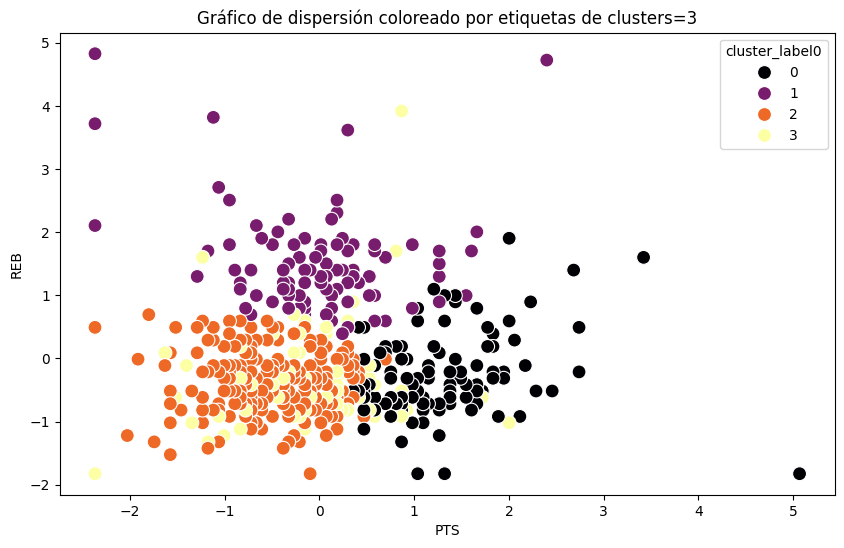

In [21]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=subset_final_normalizado, x="PTS", y="REB", hue="cluster_label0", palette="inferno", s=100)
plt.title('Gráfico de dispersión coloreado por etiquetas de clusters=3')
plt.show()

Seguramente, el cluster de color crema esta condicionado por la relacion de REB-AST o PTS-AST, vemoas los graficos en estos dos casos:

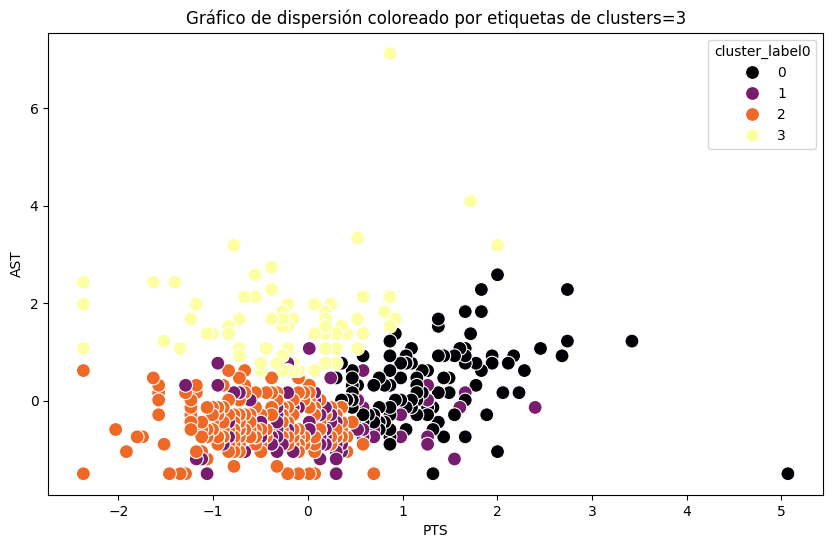

In [22]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=subset_final_normalizado, x="PTS", y="AST", hue="cluster_label0", palette="inferno", s=100)
plt.title('Gráfico de dispersión coloreado por etiquetas de clusters=3')
plt.show()

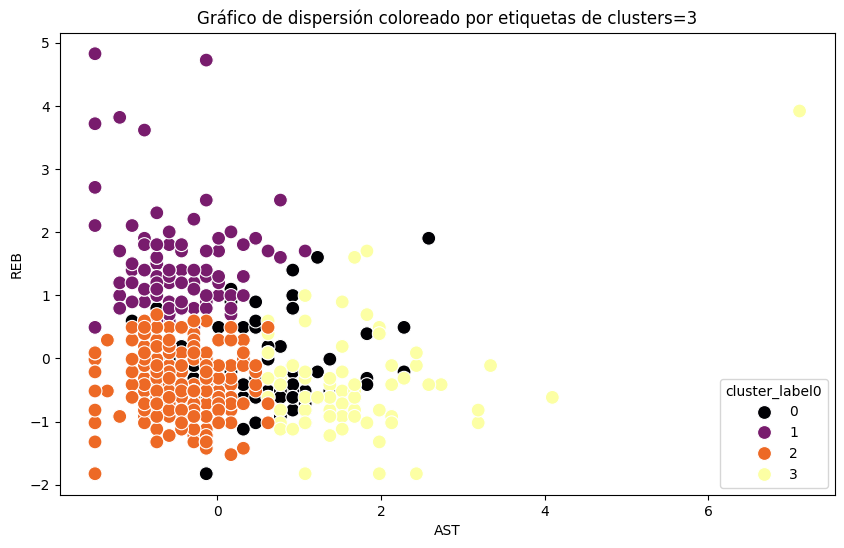

In [23]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=subset_final_normalizado, x="AST", y="REB", hue="cluster_label0", palette="inferno", s=100)
plt.title('Gráfico de dispersión coloreado por etiquetas de clusters=3')
plt.show()

Veamos que sucede ahora al hacer el analisis por DBSCAN:

Estimated number of clusters: 3
Estimated number of noise points: 219


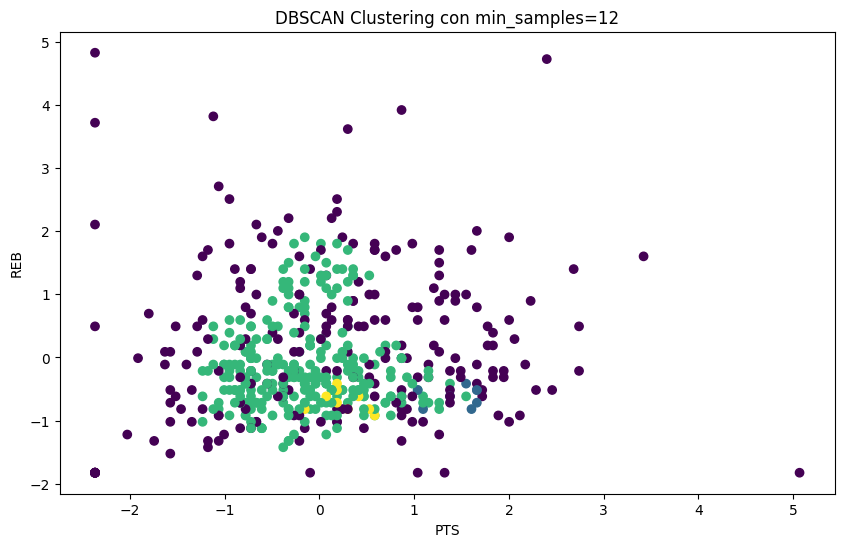

In [24]:
# Supongamos que 'subset4a' es tu DataFrame con las columnas 'pts', 'reb', y 'ast'
X_data = subset_final_normalizado[['PTS', 'REB', 'AST']].values

# Escalar los datos para que tengan media cero y desviación estándar uno
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_data)

# Aplicar DBSCAN
db = DBSCAN(eps=0.4, min_samples=8).fit(X_scaled)
labels = db.labels_

# Análisis de Resultados de DBSCAN
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

# Crear DataFrame para Visualización
datasetDBSCAN = pd.DataFrame({"PTS": X_data[:, 0],
                              "REB": X_data[:, 1],
                              "AST": X_data[:, 2],
                              "label": labels})

# Visualización de Resultados
plt.figure(figsize=(10, 6))
plt.scatter(datasetDBSCAN.PTS, datasetDBSCAN.REB, c=datasetDBSCAN.label, cmap='viridis')
plt.title("DBSCAN Clustering con min_samples=12")
plt.xlabel('PTS')
plt.ylabel('REB')
plt.show()


Nuevamente el DBSCAN vuelve a mostrar dos cosas. Lo primero que es muy util para detectar outliers. Lo segundo es que necesitamos conocer una funcion para optimizar dicho calculo, ya que varia muchisimo dependiendo los parametros que le fijemos.

Como conclusion general puedo decir que al afinar nuestro data set en base a definir los estadisticos por minuto jugado, tenemos una mayor facilidad para agrupar los tipos de jugadores que existen en la NBA. Si bien en este caso solamente aplicamos para la temporada 2022-2023, tambien seria aplicable esta modalidad temporada tras temporada. Esto nos permitiria tener datos mas precisos, sin la necesidad de limpiar la base de datos ni hacer supuestos que ayuden con la interpretacion de la estimacion pero que resten en utilidad del mismo.

### <font color='#197D75'> 2. Clasificacion con etiquetas </font>

#### <font color='#197D75'> 2.1 KMeans </font>

Ahora vamos a tomar toda la base de datos inicial, y entrenar nuestro modelo para que sea capaz de interpretar la posicion de cada jugador. Nuevamente, hacemos la salvedad de que si bien conocemos que hoy en dia la NBA cuanta con jugadores que hacen todo, al enfocar nuestros estadisticos en los minutos jugados podemos ver las claras diferencias que existen entre los jugadores de elite con el resto. Si bien el objetivo ahora es poder identificar la posicion del jugador, el foco de analisis no cambia: mientras mas separabilidad tengamos en los datos observados, mayor facilidad para identificar correctamente. Veremos que sucede en este caso:

In [25]:
datos_merge.head()

,ID_Player,PLAYER,TEAM,AGE,GP,W,L,MIN,PTS,FGM,...,FP,DD2,TD3,+/-,NUMBER,POSITION,LAST ATTENDED,COUNTRY,es_lebron,es_curry
0,1,Jay Huff,DEN,26,2,2,0,1.5,1.31,0.65,...,1.31,0.0,0.0,-2.61,30.0,C,Virginia,USA,0,0
2,3,Joel Embiid,PHI,29,25,20,5,854.1,1.02,0.34,...,1.86,21.0,1.0,0.29,21.0,C-F,Kansas,Cameroon,0,0
3,4,Luka Doncic,DAL,24,31,19,12,1145.5,0.90,0.31,...,1.61,21.0,6.0,0.05,77.0,F-G,Real Madrid,Slovenia,0,0
4,5,Shai Gilgeous-Alexander,OKC,25,30,22,8,1040.8,0.90,0.32,...,1.61,3.0,0.0,0.29,2.0,G,Kentucky,Canada,0,0
5,6,Giannis Antetokounmpo,MIL,29,32,23,9,1115.2,0.89,0.33,...,1.63,24.0,3.0,0.17,34.0,F,Filathlitikos,Greece,0,0


Vamos a hacer algunos ajustes respecto a las variables seleccionadas en nuestro trabajo anterior. Como ahora nuestro objetivo ha cambiado, hay que focalizar mas nuestro input: debemos diferenciar los rebotes agarrados de manera ofensiva y de manera defensiva; debemos agregar robos (STL), bloqueos (BLK), faltas personales (PF) y puntos de fantasia (FP). Obviamente, al ser un modelo predictivo con etiquetas, nos vamos a quedar tambien con las posisiones de los jugadres, ya que son las que ayudaran a entrenar el modelo para luego poder predecir. Lo primero que haremos es hacer un subset con estas variables, ya que luego deberiamos normalizarlas. 

In [26]:
columnas_interes = ["PTS", "DREB", "OREB", "AST", "STL", "BLK", "FP", "PF", "POSITION"]
subset_datos = datos_merge[columnas_interes].copy()
subset_datos.head()

,PTS,DREB,OREB,AST,STL,BLK,FP,PF,POSITION
0,1.31,0.00,0.00,0.00,0.00,0.00,1.31,0.00,C
2,1.02,0.26,0.08,0.18,0.03,0.06,1.86,0.08,C-F
3,0.90,0.20,0.02,0.25,0.04,0.02,1.61,0.05,F-G
4,0.90,0.14,0.02,0.18,0.08,0.02,1.61,0.07,G
5,0.89,0.25,0.08,0.16,0.04,0.03,1.63,0.08,F


In [27]:
# Agrupa los datos por la columna 'POSITION'
grupo_por_posicion = subset_datos.groupby('POSITION')

# Calcula las medias para cada grupo
medias_por_posicion = grupo_por_posicion.mean()

# Muestra el resultado
print(medias_por_posicion)

               PTS      DREB      OREB       AST       STL       BLK  \
POSITION                                                               
C         0.429512  0.219756  0.108780  0.072683  0.020488  0.043415   
C-F       0.448500  0.202000  0.092500  0.068500  0.027000  0.052500   
F         0.388038  0.138291  0.048418  0.081519  0.029937  0.021329   
F-C       0.472187  0.188750  0.081250  0.083750  0.025937  0.032500   
F-G       0.448125  0.126875  0.036250  0.100625  0.035000  0.013125   
G         0.430212  0.097513  0.031164  0.126508  0.038730  0.013016   
G-F       0.386316  0.103947  0.030526  0.091053  0.031579  0.010526   

                FP        PF  
POSITION                      
C         1.079268  0.118049  
C-F       1.082500  0.111000  
F         0.841962  0.091962  
F-C       1.038437  0.105625  
F-G       0.894375  0.075000  
G         0.869206  0.075079  
G-F       0.768684  0.082895  


Realizamos un analisis de las correlaciones de nuestros datos:

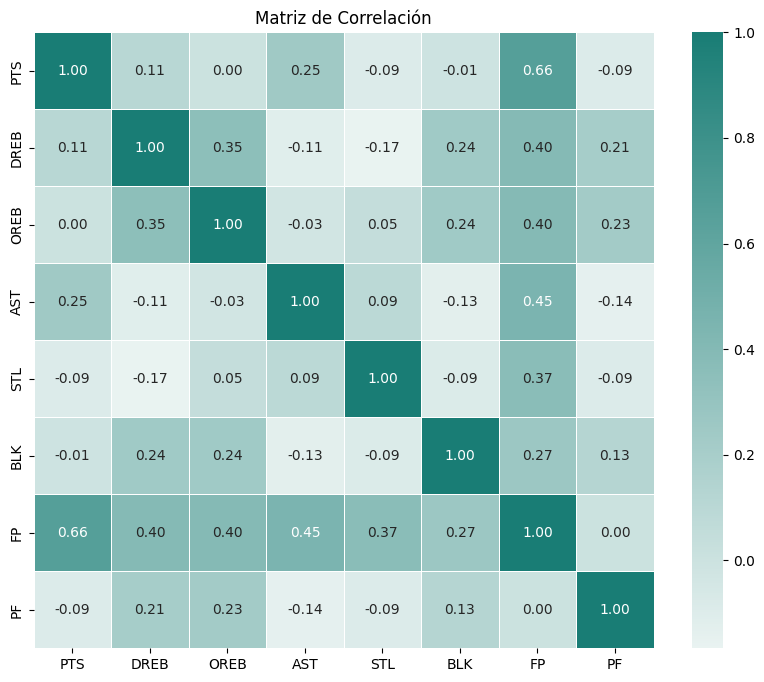

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
sub_set = subset_datos.drop(columns=['POSITION'])

# Calcular la matriz de correlación
correlation_matrix = sub_set.corr()

# Define tu propio esquema de color verde
green_cmap = sns.light_palette("#197D75", as_cmap=True)

# Crear un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap=green_cmap, fmt=".2f", linewidths=.5)
plt.title("Matriz de Correlación")
plt.show()


No hay correlaciones lineales muy fuertes entre nuestras variables, ni positivas ni negativas. Esto a priori podria ser un buen indicadores si en terminos teoricos decidimos introducir todas estas variables en nuestro modelo.

Analicemos un poco nuestra variable objetivo. Las posiciones en la NBA son abreviaturas que describen la función principal de un jugador en el campo. Hoy en dia, la versatilidad de los jugadores les permite desempeñar roles que van mas allá de las categorias tradicionales. Las estrategias de juego y las tacticas de los equipos tambien influyen en como se utilizan los jugadores en diferentes posiciones.

<font color='#197D75'> **C (Center):** </font> El centro suele ser el jugador más alto del equipo y juega cerca del aro. Sus responsabilidades incluyen rebotes, bloqueos de tiros y anotaciones de corta distancia. Suelen ser jugadores fisicamente fuertes.

<font color='#197D75'> **C-F (Center-Forward):** </font> Esta posicion combina las características del centro y el ala-pivot. Puede jugar tanto cerca del aro como a distancias intermedias. A menudo, un C-F es versatil y puede realizar diversas funciones.

<font color='#197D75'> **F-C (Forward-Center):** </font> Similar a C-F, esta posición combina características de ala-pívot y centro. Puede jugar tanto en el perímetro como en la pintura.

<font color='#197D75'> **F (Forward):** </font> Los ala-pivots y los aleros son jugadores que suelen jugar en posiciones intermedias entre el perimetro y la pintura. Los ala-pivots pueden ser fuertes y buenos reboteadores, mientras que los aleros suelen ser jugadores versatiles y atleticos.

<font color='#197D75'> **F-G (Forward-Guard):** </font> Esta posicion combina características de alero y escolta. Los jugadores F-G son versatiles y pueden contribuir tanto en el juego perimetral como en situaciones cerca del aro.

<font color='#197D75'> **G-F (Guard-Forward):** </font> Similar a F-G, esta posición combina características de escolta y alero. Estos jugadores son versatiles en sus habilidades y pueden adaptarse a diferentes roles en la cancha.

<font color='#197D75'> **G (Guard):** </font>  Los escoltas (guards) son jugadores cuyas habilidades se centran en el juego perimetral. Pueden ser escoltas armadores (point guards), especializados en facilitar el juego y tomar decisiones tácticas, o escoltas anotadores (shooting guards), que se destacan en la anotación y el tiro exterior.


In [29]:
# Agrupa los datos por la columna 'POSITION' y cuenta el tamaño de cada grupo
observaciones_por_posicion = subset_datos.groupby('POSITION').size().reset_index(name='Count')

# Muestra el resultado
print(observaciones_por_posicion)


  POSITION  Count
0        C     41
1      C-F     20
2        F    158
3      F-C     32
4      F-G     16
5        G    189
6      G-F     38


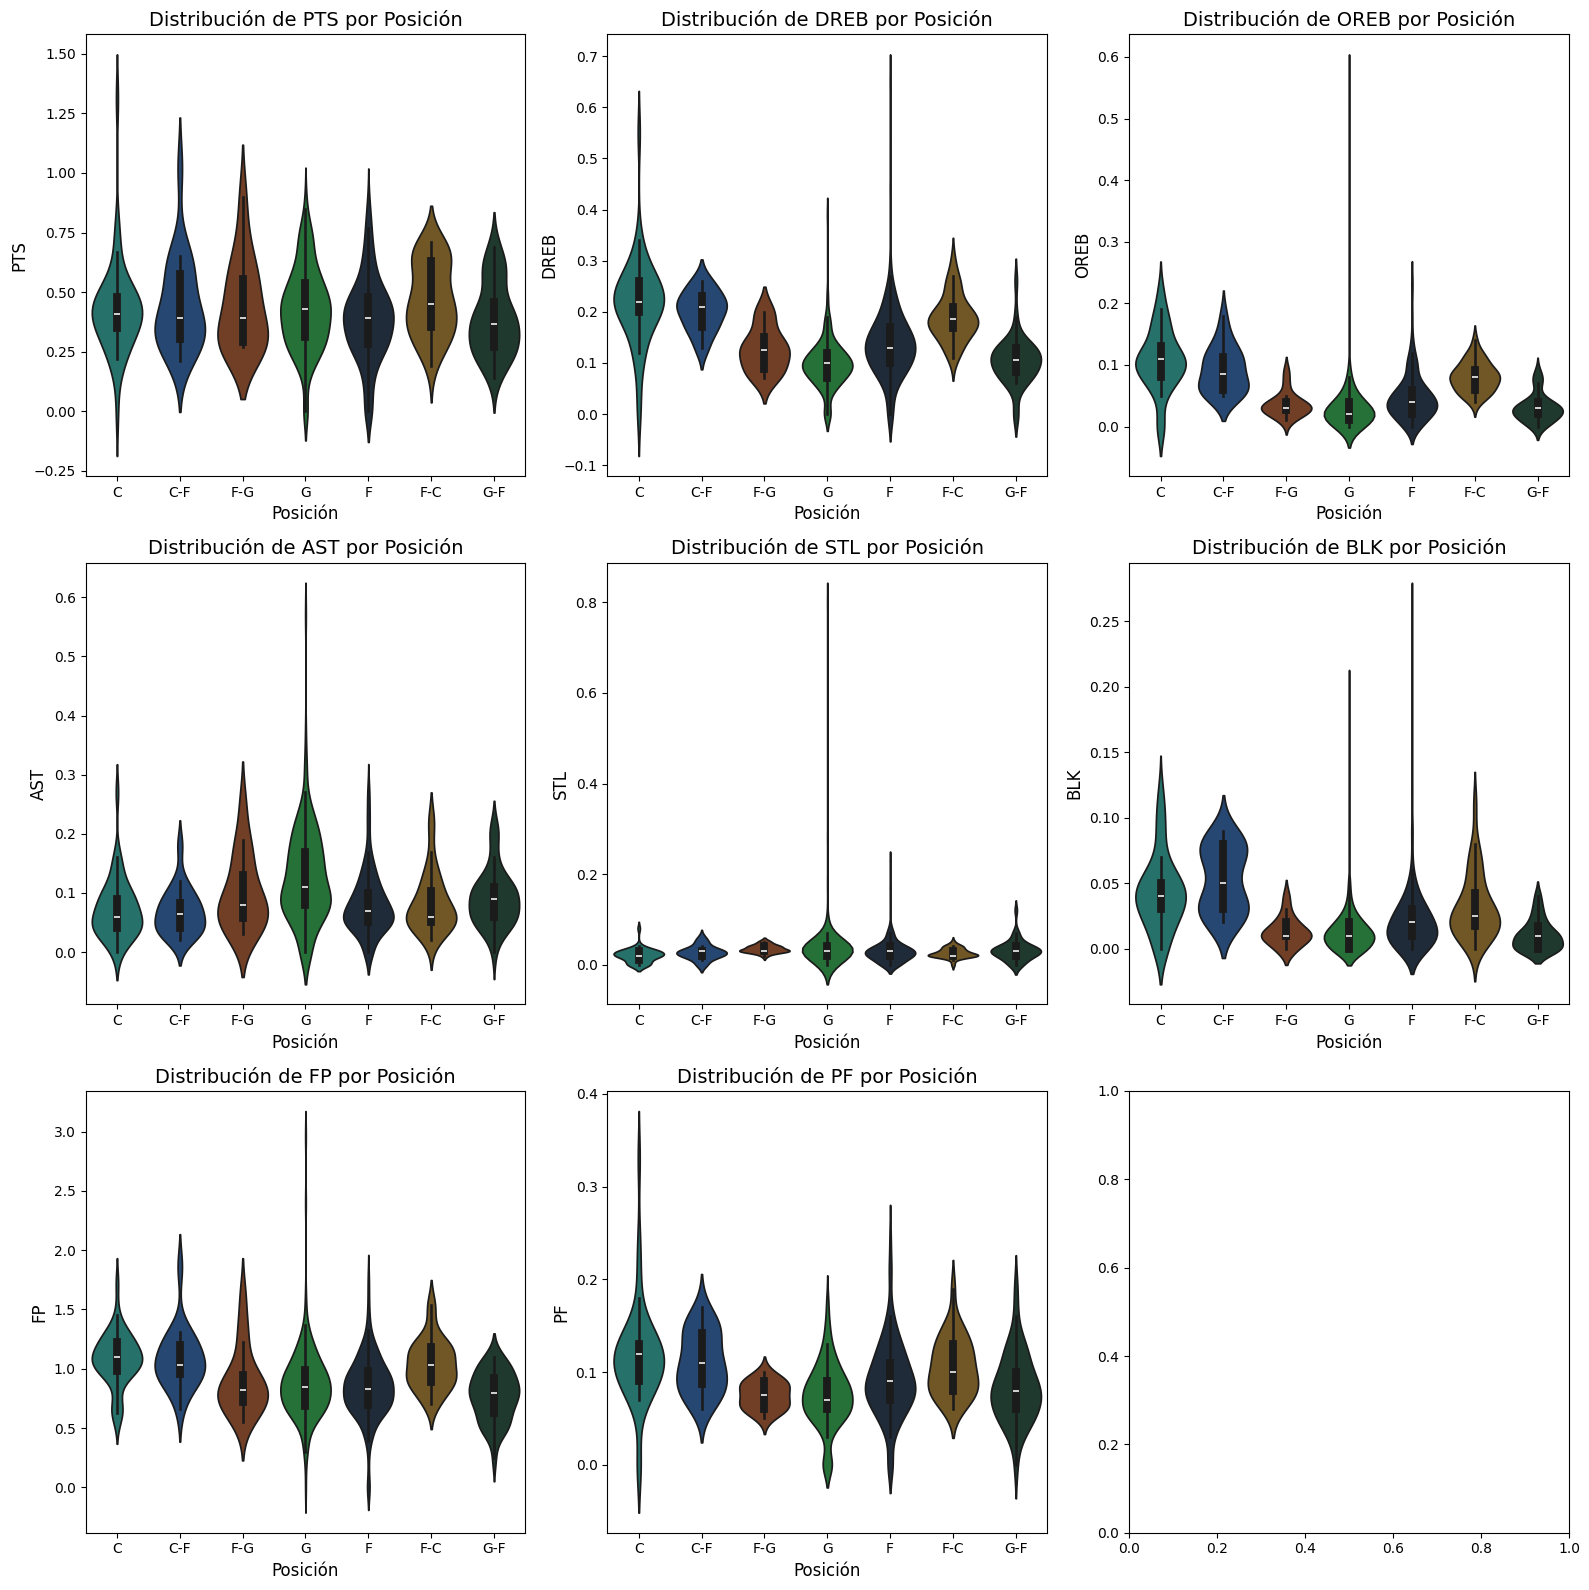

In [30]:
import seaborn as sns

# Crear subplots con 3 filas y 3 columnas (ajusta según sea necesario)
fig, axes = plt.subplots(3, 3, figsize=(16, 16))

# Variables de interés
variables_interes = ["PTS", "DREB", "OREB", "AST", "STL", "BLK", "FP", "PF"]

# Paleta de colores para cada grupo (ajusta según sea necesario)
color_palette = ["#197D75", "#19467D", "#7D3A19", "#197D31", "#1C2B3D", "#7D5A19", "#1C3D2F"]

# Recorrer las variables de interés y crear gráficos de violín
for i, variable in enumerate(variables_interes):
    fila = i // 3
    columna = i % 3

    # Crear gráfico de violín para la variable actual
    sns.violinplot(ax=axes[fila, columna], x='POSITION', y=variable, data=subset_datos, inner='box', width=0.8, palette=color_palette, hue='POSITION', legend=False)
    
    # Configurar etiquetas y título
    axes[fila, columna].set_xlabel('Posición', fontsize=12)
    axes[fila, columna].set_ylabel(variable, fontsize=12)
    axes[fila, columna].set_title(f'Distribución de {variable} por Posición', fontsize=14)

# Ajustar el diseño y mostrar los gráficos
plt.tight_layout()
plt.show()


Podemos observar que no son homogeneas las distribuciones para cada posicion, lo que puede aproximarnos a cierta variabilidad entre los grupos. Sin embargo, debemos seguir estudiando esto para ver que sucede con nuestros modelos de categorizacion.

In [31]:
from sklearn.preprocessing import StandardScaler

# Selecciona solo las columnas numéricas para la normalización
columnas_numericas = subset_datos.columns.difference(['POSITION'])

# Crea un objeto StandardScaler
scaler = StandardScaler()

# Normaliza las columnas numéricas
subset_datos[columnas_numericas] = scaler.fit_transform(subset_datos[columnas_numericas])
subset_datos.head()

,PTS,DREB,OREB,AST,STL,BLK,FP,PF,POSITION
0,5.067940,-1.849492,-1.015884,-1.495377,-0.762101,-0.841141,1.488528,-2.161983,C
2,3.421532,1.785531,0.643799,1.224380,-0.057086,1.577037,3.440614,-0.198260,C-F
3,2.740260,0.946679,-0.600963,2.282063,0.177919,-0.035082,2.553302,-0.934656,F-G
4,2.740260,0.107828,-0.600963,1.224380,1.117938,-0.035082,2.553302,-0.443726,G
5,2.683487,1.645722,0.643799,0.922185,0.177919,0.367948,2.624287,-0.198260,F


In [32]:
# Crear un objeto LabelEncoder
label_encoder = LabelEncoder()

# Aplicar la codificación a la última columna de subset_datos
subset_datos['POSITION'] = label_encoder.fit_transform(subset_datos['POSITION'])

In [33]:
from sklearn.model_selection import train_test_split

X_train = subset_datos.drop(columns=['POSITION'])  # Excluye la columna 'POSITION' de las características
y_class = subset_datos['POSITION']

X_train, X_test, Y_train, Y_test = train_test_split(X_train, y_class, test_size=0.20, random_state=4)
print("Tamaño dataset entrenamiento:",X_train.shape)
print("Tamaño dataset validación:",X_test.shape)

Tamaño dataset entrenamiento: (395, 8)
Tamaño dataset validación: (99, 8)


In [34]:
# Generación del modelo con 3 clústeres y predicción de éste
Kmeans_nba = KMeans(n_clusters=3, random_state=0, n_init=10).fit(X_train)

# Una vez el algoritmo se ha entrenado, generar predicciones
pred_Kmeans_nba = Kmeans_nba.predict(X_test)

# Calcula y muestra la matriz de confusión
print("Matriz de confusión para KMeans:")
conf_matrix = confusion_matrix(Y_test, pred_Kmeans_nba)
print(conf_matrix)

# Calcula y muestra la precisión
accuracy = accuracy_score(Y_test, pred_Kmeans_nba)
print(f"Precisión del modelo: {accuracy:.2f}")


Matriz de confusión para KMeans:
[[ 0  5  0  0  0  0  0]
 [ 1  4  0  0  0  0  0]
 [18  8  7  0  0  0  0]
 [ 1  4  1  0  0  0  0]
 [ 5  0  1  0  0  0  0]
 [24  0 12  0  0  0  0]
 [ 5  0  3  0  0  0  0]]
Precisión del modelo: 0.11


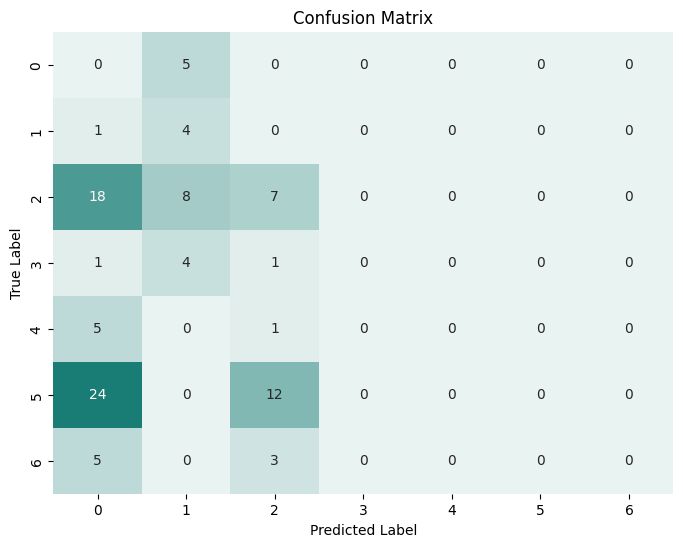

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calcula la matriz de confusión
conf_matrix = confusion_matrix(Y_test, pred_Kmeans_nba)

# Define tu propio esquema de color verde
green_cmap = sns.light_palette("#197D75", as_cmap=True)

# Crea un mapa de calor con la matriz de confusión usando el esquema de color verde
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=green_cmap, cbar=False)

# Configura etiquetas y título
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

# Muestra el gráfico
plt.show()

Dados estos resultados, tengo tres opciones de mejorar mi calculo. La primera de ellas es plantear un modelo PCA para determinar con todas las variables que tenemos cuales ayudan a explicar mejor la posicion del jugador. Esto llevaria mayor analisis en este apartado y no seria adecuado para la realizacion de este trabajo practico. La segunda de ellas es plantear un agrupamiento por posicion tradicional de los jugadores: F, G, C. Es decir, si el jugador es F-G o G-F, se encontrara en una misma categoria. Veremos que sucede al implementar esta mejora:

In [36]:
columnas_interes = ["PTS", "DREB", "OREB", "MIN", "AST", "STL", "BLK", "FP", "PF", "POSITION"]
subset_datos2 = datos_merge[columnas_interes].copy()
subset_datos2.head()

,PTS,DREB,OREB,MIN,AST,STL,BLK,FP,PF,POSITION
0,1.31,0.00,0.00,1.5,0.00,0.00,0.00,1.31,0.00,C
2,1.02,0.26,0.08,854.1,0.18,0.03,0.06,1.86,0.08,C-F
3,0.90,0.20,0.02,1145.5,0.25,0.04,0.02,1.61,0.05,F-G
4,0.90,0.14,0.02,1040.8,0.18,0.08,0.02,1.61,0.07,G
5,0.89,0.25,0.08,1115.2,0.16,0.04,0.03,1.63,0.08,F


In [37]:
subset_datos2['POSITION2'] = subset_datos2['POSITION'].str[0]
# Agrupa los datos por la columna 'POSITION' y cuenta el tamaño de cada grupo
observaciones_por_posicion = subset_datos2.groupby('POSITION2').size().reset_index(name='Count')
# Muestra el resultado
print(observaciones_por_posicion)


  POSITION2  Count
0         C     61
1         F    206
2         G    227


In [38]:
# Crear un objeto LabelEncoder
label_encoder = LabelEncoder()

# Aplicar la codificación a la última columna de subset_datos
subset_datos2['POSITION2'] = label_encoder.fit_transform(subset_datos2['POSITION2'])
subset_datos2.head()

,PTS,DREB,OREB,MIN,AST,STL,BLK,FP,PF,POSITION,POSITION2
0,1.31,0.00,0.00,1.5,0.00,0.00,0.00,1.31,0.00,C,0
2,1.02,0.26,0.08,854.1,0.18,0.03,0.06,1.86,0.08,C-F,0
3,0.90,0.20,0.02,1145.5,0.25,0.04,0.02,1.61,0.05,F-G,1
4,0.90,0.14,0.02,1040.8,0.18,0.08,0.02,1.61,0.07,G,2
5,0.89,0.25,0.08,1115.2,0.16,0.04,0.03,1.63,0.08,F,1


In [39]:
# Excluye la columna 'POSITION' y 'POSTION2' de las características
X_train = subset_datos2.drop(columns=['POSITION', 'POSITION2'])
y_class = subset_datos2['POSITION2']

# Realiza la división entre conjunto de entrenamiento y conjunto de prueba
X_train, X_test, Y_train, Y_test = train_test_split(X_train, y_class, test_size=0.20, random_state=4)

# Imprime el tamaño de los conjuntos
print("Tamaño dataset entrenamiento:", X_train.shape)
print("Tamaño dataset validación:", X_test.shape)

Tamaño dataset entrenamiento: (395, 9)
Tamaño dataset validación: (99, 9)


In [40]:
# Generación del modelo con 3 clústeres y predicción de éste
Kmeans_nba2 = KMeans(n_clusters=3, random_state=0, n_init=10).fit(X_train)

# Una vez el algoritmo se ha entrenado, generar predicciones
pred_Kmeans_nba2 = Kmeans_nba2.predict(X_test)

# Calcula y muestra la matriz de confusión
print("Matriz de confusión para KMeans:")
conf_matrix = confusion_matrix(Y_test, pred_Kmeans_nba2)
print(conf_matrix)

# Calcula y muestra la precisión
accuracy = accuracy_score(Y_test, pred_Kmeans_nba2)
print(f"Precisión del modelo: {accuracy:.2f}")


Matriz de confusión para KMeans:
[[ 3  5  2]
 [11 27  7]
 [ 9 21 14]]
Precisión del modelo: 0.44


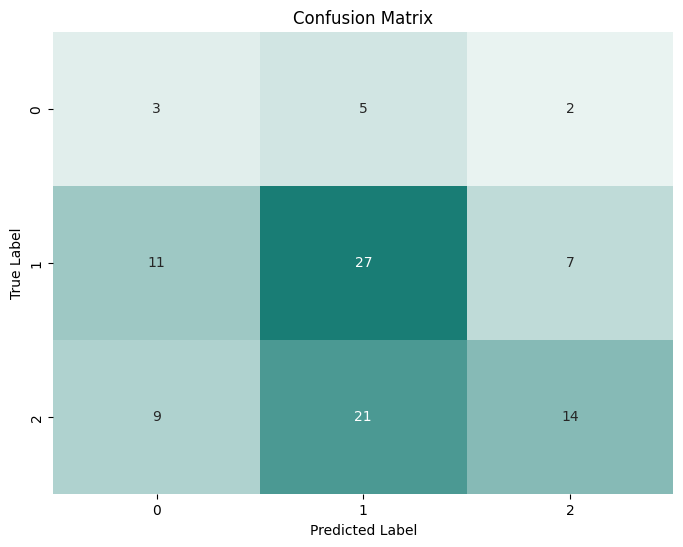

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calcula la matriz de confusión
conf_matrix = confusion_matrix(Y_test, pred_Kmeans_nba2)

# Define tu propio esquema de color verde
green_cmap = sns.light_palette("#197D75", as_cmap=True)

# Crea un mapa de calor con la matriz de confusión usando el esquema de color verde
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=green_cmap, cbar=False)

# Configura etiquetas y título
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

# Muestra el gráfico
plt.show()

Claramente el modelo mejoro, pero aun sigue siendo bastante pobre para poder definir la posicion del jugador. Nuestra capacidad predictiva evaluada bajo la accuracy es del 40%. Recordemos que el modelo no se encuentra balanceado en cantidad de jugadores por posicion, esto podria estar aumentando el error de nuestra estimacion.

Ahora si, pasemos a realizar las estimaciones de nuestros modelos de clasificacion KNN, Arboles de decision y Regresion simple.

#### <font color='#197D75'> 2.2 KNN </font>

Ahora si entramos en el nucleo de este ejercicio. Es importante volver a recordar nuestro objetivo: queremos tener un modelo que pueda predecir correctamente la posicion de nuestro jugador. Hemos decidio proceder con las posiciones tradicionales del juego, siendo 3 en general. Es por esta razon que nuestra clasificacion es multiclase, con lo cual, pasaremos a estimar nuestras categorias usando el metodo de KNN realizando iteraciones con tres valores diferentes n=(2;4;6). Para ello, debemos realizar ciertas correcciones previas sobre nuestra base de datos. La primero que haremos es pasar a numerico nuestra variable categorica. Es decir, vamos a cambiar los nombres de las variables de la variable posicion de la siguiente manera: 0 será "C", 1 será "F", 2 será "G". Luego separaremos nuestra base de datos en variables atributos y etiquetas, para poder entrenar a nuestro futuro modelo. Previo a dividir nuestro data set en train y test, vamos a normalizar los datos. Esto se sustenta en la misma justificacion que dimos para el trabajo pasado. Recien ahi podremos realizar la estimacion de nuestro modelo.

In [42]:
columnas_interes = ["PTS", "DREB", "OREB", "MIN", "AST", "STL", "BLK", "FP", "PF", "POSITION"]
subset_datos3 = datos_merge[columnas_interes].copy()
subset_datos3.head()

,PTS,DREB,OREB,MIN,AST,STL,BLK,FP,PF,POSITION
0,1.31,0.00,0.00,1.5,0.00,0.00,0.00,1.31,0.00,C
2,1.02,0.26,0.08,854.1,0.18,0.03,0.06,1.86,0.08,C-F
3,0.90,0.20,0.02,1145.5,0.25,0.04,0.02,1.61,0.05,F-G
4,0.90,0.14,0.02,1040.8,0.18,0.08,0.02,1.61,0.07,G
5,0.89,0.25,0.08,1115.2,0.16,0.04,0.03,1.63,0.08,F


Hagamos una evaluacion respecto a la calidad de los datos que contamos para realizar nuestra prediccion:

In [43]:
# Visualizar valores nulos en subset_datos3
nulos = subset_datos3.isnull().sum()

# Mostrar el total de valores nulos por columna
print(nulos)

PTS         0
DREB        0
OREB        0
MIN         0
AST         0
STL         0
BLK         0
FP          0
PF          0
POSITION    0
dtype: int64


Observamos que no tenemos ningun dato nulo, con lo cual nuestra base de datos se encuentra completo (logico, ya que lo habiamos limpiado luego de hacer el merge).

In [44]:
subset_datos3['POSITION2'] = subset_datos3['POSITION'].str[0]
observaciones_por_posicion = subset_datos3.groupby('POSITION2').size().reset_index(name='Count')
# Muestra el resultado
print(observaciones_por_posicion)


  POSITION2  Count
0         C     61
1         F    206
2         G    227


Vemos nuevamente que nuestro modelo no se encuentra perfectamente balanceado. La posicion "C" tiene notablemente menos observaciones que las otras dos. Esto podria causar un problema ya que no solo dificultaria la prediccion de una posicion C, sino que ademas, estaremos ensuciando las estimaciones de las otras posiciones, si no hay una separabilidad en los datos lo suficientemente grande.

In [45]:
#Eliminamos la variable POSITION
subset_datos3.drop('POSITION', axis=1, inplace=True)
# Crear un objeto LabelEncoder
label_encoder = LabelEncoder()

# Aplicar la codificación a la última columna de subset_datos
subset_datos3['POSITION2'] = label_encoder.fit_transform(subset_datos3['POSITION2'])
subset_datos3.head()

,PTS,DREB,OREB,MIN,AST,STL,BLK,FP,PF,POSITION2
0,1.31,0.00,0.00,1.5,0.00,0.00,0.00,1.31,0.00,0
2,1.02,0.26,0.08,854.1,0.18,0.03,0.06,1.86,0.08,0
3,0.90,0.20,0.02,1145.5,0.25,0.04,0.02,1.61,0.05,1
4,0.90,0.14,0.02,1040.8,0.18,0.08,0.02,1.61,0.07,2
5,0.89,0.25,0.08,1115.2,0.16,0.04,0.03,1.63,0.08,1


In [46]:
from sklearn.model_selection import train_test_split

# Excluye la columna 'POSITION' y 'POSTION2' de las características
X_train = subset_datos3.drop(columns=['POSITION2'])
y_class = subset_datos3['POSITION2']

# Realiza la división entre conjunto de entrenamiento y conjunto de prueba
X_train, X_test, Y_train, Y_test = train_test_split(X_train, y_class, test_size=0.15, random_state=4)

# Imprime el tamaño de los conjuntos
print("Tamaño dataset entrenamiento:", X_train.shape)
print("Tamaño dataset validación:", X_test.shape)

Tamaño dataset entrenamiento: (419, 9)
Tamaño dataset validación: (75, 9)


Decido darle un mayor tamanio a la base de entrenamiento, ya que al no estar balanceada, necesito que tome la mayor variabilidad de datos posible. Es por ello que nuestro data_train sera del 85%, mientras que nuestro data_test sera de 15%.

In [47]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Estandarización (z-score)
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)


In [48]:
# K values
k_values = [2, 4, 6]

# Saving results
precisions = []
confusion_matrices = []

# Cross validation w/ diff K values
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)

    # 5-Fold Stratified Cross-Validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    y_pred = cross_val_predict(knn, X_train_standardized, Y_train, cv=cv)

    # Confusion matrices
    cm = confusion_matrix(Y_train, y_pred)
    confusion_matrices.append(cm)

    # Precision
    precision = np.mean(y_pred == Y_train)
    precisions.append(precision)

# Print results
for k, precision, cm in zip(k_values, precisions, confusion_matrices):
    print(f"K-value: {k}")
    print("Accuracy:", precision)
    print("Confusion matrix:")
    print(cm)
    print()
    print(classification_report(Y_train, y_pred))
    print("="*50)


K-value: 2
Accuracy: 0.5608591885441527
Confusion matrix:
[[ 38  14   1]
 [ 36 103  32]
 [  3  98  94]]

              precision    recall  f1-score   support

           0       0.58      0.64      0.61        53
           1       0.55      0.60      0.58       171
           2       0.72      0.64      0.67       195

    accuracy                           0.62       419
   macro avg       0.61      0.63      0.62       419
weighted avg       0.63      0.62      0.63       419

K-value: 4
Accuracy: 0.5966587112171837
Confusion matrix:
[[ 36  15   2]
 [ 30  99  42]
 [  1  79 115]]

              precision    recall  f1-score   support

           0       0.58      0.64      0.61        53
           1       0.55      0.60      0.58       171
           2       0.72      0.64      0.67       195

    accuracy                           0.62       419
   macro avg       0.61      0.63      0.62       419
weighted avg       0.63      0.62      0.63       419

K-value: 6
Accuracy: 0.62291

Aun las modificaciones realizadas de nuestra base de datos y los agrupamientos de nuestra variable categorica, nos siguen arrojando estimaciones bastante malas de nuestro modelo de clasificacion bajo KNN. Voy a probar nuevamente esta estimacion quedandome con las variables principales: PTS, OREB, DREB y AST.

In [49]:
columnas_interes = ["PTS", "DREB", "OREB", "AST", "POSITION"]
subset_datos4 = datos_merge[columnas_interes].copy()
subset_datos4['POSITION2'] = subset_datos4['POSITION'].str[0]
subset_datos4.head()

,PTS,DREB,OREB,AST,POSITION,POSITION2
0,1.31,0.00,0.00,0.00,C,C
2,1.02,0.26,0.08,0.18,C-F,C
3,0.90,0.20,0.02,0.25,F-G,F
4,0.90,0.14,0.02,0.18,G,G
5,0.89,0.25,0.08,0.16,F,F


In [50]:
#Eliminamos la variable POSITION
subset_datos4.drop('POSITION', axis=1, inplace=True)
# Crear un objeto LabelEncoder
label_encoder = LabelEncoder()

# Aplicar la codificación a la última columna de subset_datos
subset_datos4['POSITION2'] = label_encoder.fit_transform(subset_datos4['POSITION2'])
subset_datos4.head()

,PTS,DREB,OREB,AST,POSITION2
0,1.31,0.00,0.00,0.00,0
2,1.02,0.26,0.08,0.18,0
3,0.90,0.20,0.02,0.25,1
4,0.90,0.14,0.02,0.18,2
5,0.89,0.25,0.08,0.16,1


In [51]:
# Excluye la columna 'POSITION' y 'POSTION2' de las características
X_train = subset_datos4.drop(columns=['POSITION2'])
y_class = subset_datos4['POSITION2']

# Realiza la división entre conjunto de entrenamiento y conjunto de prueba
X_train, X_test, Y_train, Y_test = train_test_split(X_train, y_class, test_size=0.15, random_state=4)

# Imprime el tamaño de los conjuntos
print("Tamaño dataset entrenamiento:", X_train.shape)
print("Tamaño dataset validación:", X_test.shape)

Tamaño dataset entrenamiento: (419, 4)
Tamaño dataset validación: (75, 4)


In [52]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Estandarización (z-score)
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)
X_train_standardized

array([[ 0.76810729, -0.31888922, -0.59711028, -0.40885515],
       [-0.31360192, -0.60872562, -0.79806547,  0.0491938 ],
       [-2.02156383, -1.33331663, -0.59711028, -0.56153814],
       ...,
       [-1.05371874, -0.75364382, -0.3961551 , -0.71422112],
       [ 0.25571872, -0.46380742, -0.79806547,  2.0340726 ],
       [ 0.5973111 , -0.02905281, -0.79806547,  2.18675558]])

In [53]:
# K values
k_values = [2, 4, 6]

# Saving results
precisions = []
confusion_matrices = []

# Cross validation w/ diff K values
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)

    # 5-Fold Stratified Cross-Validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    y_pred = cross_val_predict(knn, X_train_standardized, Y_train, cv=cv)

    # Confusion matrices
    cm = confusion_matrix(Y_train, y_pred)
    confusion_matrices.append(cm)

    # Precision
    precision = np.mean(y_pred == Y_train)
    precisions.append(precision)

# Print results
for k, precision, cm in zip(k_values, precisions, confusion_matrices):
    print(f"K-value: {k}")
    print("Accuracy:", precision)
    print("Confusion matrix:")
    print(cm)
    print()
    print(classification_report(Y_train, y_pred))
    print("="*50)


K-value: 2
Accuracy: 0.5393794749403341
Confusion matrix:
[[ 34  16   3]
 [ 33 105  33]
 [  5 103  87]]

              precision    recall  f1-score   support

           0       0.56      0.57      0.56        53
           1       0.55      0.61      0.58       171
           2       0.72      0.65      0.68       195

    accuracy                           0.62       419
   macro avg       0.61      0.61      0.61       419
weighted avg       0.63      0.62      0.62       419

K-value: 4
Accuracy: 0.5918854415274463
Confusion matrix:
[[ 33  17   3]
 [ 23 106  42]
 [  4  82 109]]

              precision    recall  f1-score   support

           0       0.56      0.57      0.56        53
           1       0.55      0.61      0.58       171
           2       0.72      0.65      0.68       195

    accuracy                           0.62       419
   macro avg       0.61      0.61      0.61       419
weighted avg       0.63      0.62      0.62       419

K-value: 6
Accuracy: 0.62052

Ahora si, nuestro accuracy ha mejorado con esta modificacion de nuestra base de datos. Sin embargo, KNN clasifica un punto de datos asignándole la etiqueta que es más común entre sus k vecinos mas cercanos en el espacio de caracteristicas. La eleccion del valor de k (numero de vecinos) es un hiperparámetro importante en KNN, y diferentes valores de k pueden afectar el rendimiento del modelo. Para esto, Grid Search es una buena herramienta, ya que explora un conjunto predefinido de valores de hiperparámetros para encontrar la combinación que produce el mejor rendimiento segun una metrica especifica.n:

##### <font color='#197D75'> 2.3.1 Grid Search </font>

In [54]:
# Definir los parámetros a explorar en la cuadrícula
param_grid = {'n_neighbors': [1, 3, 5, 7, 9], 'metric': ['euclidean', 'manhattan']}

# Inicializar el modelo k-NN
knn = KNeighborsClassifier()

# Configurar la búsqueda en la cuadrícula
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

# Realizar la búsqueda en la cuadrícula en los datos de entrenamiento
grid_search.fit(X_train, Y_train)

# Obtener los mejores hiperparámetros encontrados
best_params = grid_search.best_params_

# Obtener el modelo con los mejores hiperparámetros
best_knn_model = grid_search.best_estimator_

# Imprimir los resultados
print("Mejores hiperparámetros encontrados:")
print(best_params)

print("\nModelo con los mejores hiperparámetros:")
print(best_knn_model)

# También puedes imprimir otras métricas o resultados relevantes
print("\nResultados de la búsqueda en la cuadrícula:")
print("Mejor puntuación de validación cruzada (accuracy):", grid_search.best_score_)

# Opcionalmente, imprimir detalles sobre cada combinación de hiperparámetros evaluada
print("\nDetalles de cada combinación de hiperparámetros evaluada:")
results_df = pd.DataFrame(grid_search.cv_results_)
print(results_df[['params', 'mean_test_score', 'std_test_score']])


Mejores hiperparámetros encontrados:
{'metric': 'manhattan', 'n_neighbors': 7}

Modelo con los mejores hiperparámetros:
KNeighborsClassifier(metric='manhattan', n_neighbors=7)

Resultados de la búsqueda en la cuadrícula:
Mejor puntuación de validación cruzada (accuracy): 0.6491107286288009

Detalles de cada combinación de hiperparámetros evaluada:
                                      params  mean_test_score  std_test_score
0  {'metric': 'euclidean', 'n_neighbors': 1}         0.579834        0.047185
1  {'metric': 'euclidean', 'n_neighbors': 3}         0.606081        0.061566
2  {'metric': 'euclidean', 'n_neighbors': 5}         0.634768        0.044935
3  {'metric': 'euclidean', 'n_neighbors': 7}         0.642025        0.020892
4  {'metric': 'euclidean', 'n_neighbors': 9}         0.632415        0.030044
5  {'metric': 'manhattan', 'n_neighbors': 1}         0.587063        0.038600
6  {'metric': 'manhattan', 'n_neighbors': 3}         0.584682        0.036882
7  {'metric': 'manhattan',

A traves del Grid Search para KNN podemos encontrar los parametros que optimizan nuestra estimacion. En este caso hicimos la prueba para 1,3,5,7 y 9 vecinos, utilizando tanto la distancia euclideana como la distancia de manhattan. Vemos que los hiperparametros que mejor ajustan nuestro modelo son k=7 y metrica=euclidiana, con una accuracy de aproximadamente 64,9%

In [55]:
from sklearn.model_selection import cross_val_score

# Utilizar el mejor modelo con los mejores hiperparámetros
best_knn_model = grid_search.best_estimator_

# Realizar la validación cruzada
cv_scores = cross_val_score(best_knn_model, X_train, Y_train, cv=5, scoring='accuracy')

# Imprimir los resultados de la validación cruzada
print("Resultados de la validación cruzada:")
print("Puntuaciones de cada iteración:", cv_scores)
print("Precisión media:", cv_scores.mean())
print("Desviación estándar de las puntuaciones:", cv_scores.std())


Resultados de la validación cruzada:
Puntuaciones de cada iteración: [0.66666667 0.69047619 0.60714286 0.6547619  0.62650602]
Precisión media: 0.6491107286288009
Desviación estándar de las puntuaciones: 0.029405860266222716


Estos resultados sugieren que el rendimiento del modelo es relativamente consistente, con una precisión media del 64.9%. La desviacion estandar de las puntuaciones es del 2,9%. Sin embargo, es importante considerar otros aspectos del rendimiento del modelo y posiblemente explorar más ajustes si es necesario mejorar aún más su rendimiento. En este caso, sabemos que nuestras clases no estan balanceadas, con lo cual podemos implementar otro metodo de validacion cruzada para pruebas desbalanceadas:

In [56]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Utilizar el mejor modelo con los mejores hiperparámetros
best_knn_model = grid_search.best_estimator_

# Configurar la validación cruzada estratificada
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=33)

# Realizar la validación cruzada estratificada
cv_scores_stratified = cross_val_score(best_knn_model, X_train, Y_train, cv=stratified_kfold, scoring='accuracy')

# Imprimir los resultados de la validación cruzada estratificada
print("Resultados de la validación cruzada estratificada:")
print("Puntuaciones de cada iteración:", cv_scores_stratified)
print("Precisión media:", cv_scores_stratified.mean())
print("Desviación estándar de las puntuaciones:", cv_scores_stratified.std())


Resultados de la validación cruzada estratificada:
Puntuaciones de cada iteración: [0.64285714 0.6547619  0.57142857 0.67857143 0.60240964]
Precisión media: 0.6300057372346528
Desviación estándar de las puntuaciones: 0.03828702612735448


En la validación cruzada estratificada, la precisión media es del 65.32%, con una desviación estándar más baja de alrededor del 3.82%. A pesar de tener las muestras desbalanceadas, y esperando que nuestro cross validation estratificado de una desviacion menor, nos encontramos que sucede lo contrario. La desviacion estandar para el KFold estandar es menor que para el KFold estratificado.

#### <font color='#197D75'> 2.3 Decision Tree </font>

In [57]:
columnas_interes = ["PTS", "DREB", "OREB", "AST", "POSITION"]
subset_datos4 = datos_merge[columnas_interes].copy()
subset_datos4['POSITION2'] = subset_datos4['POSITION'].str[0]
#Eliminamos la variable POSITION
subset_datos4.drop('POSITION', axis=1, inplace=True)
subset_datos4.head()

,PTS,DREB,OREB,AST,POSITION2
0,1.31,0.00,0.00,0.00,C
2,1.02,0.26,0.08,0.18,C
3,0.90,0.20,0.02,0.25,F
4,0.90,0.14,0.02,0.18,G
5,0.89,0.25,0.08,0.16,F


In [58]:
X = subset_datos4.iloc[:, :-1]
df_c = subset_datos4

for column in X.columns:
    if subset_datos4[column].dtypes == object:
        df_c[column] =subset_datos4df[column].astype("category").cat.codes

df_c

,PTS,DREB,OREB,AST,POSITION2
0,1.31,0.00,0.00,0.00,C
2,1.02,0.26,0.08,0.18,C
3,0.90,0.20,0.02,0.25,F
4,0.90,0.14,0.02,0.18,G
5,0.89,0.25,0.08,0.16,F
...,...,...,...,...,...
512,0.00,0.00,0.00,0.00,F
513,0.00,0.00,0.00,0.00,F
515,0.00,0.23,0.00,0.14,G
516,0.00,0.00,0.00,0.00,G


In [59]:
# Separar en atributos (X) y etiquetas (y)
X = df_c.iloc[:, :-1].values
y = df_c.iloc[:, -1].values

X


array([[1.31, 0.  , 0.  , 0.  ],
       [1.02, 0.26, 0.08, 0.18],
       [0.9 , 0.2 , 0.02, 0.25],
       ...,
       [0.  , 0.23, 0.  , 0.14],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.17]])

In [60]:
# Escalar los atributos
scaler = StandardScaler()
scaler.fit(X)

X_scaled = scaler.transform(X)

In [61]:
# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [62]:
model_params={
    'max_leaf_nodes':[50,100,500,5000],
    'min_samples_split':[2,4,6]
}

In [63]:
model = DecisionTreeClassifier(random_state=1234)
gscv = GridSearchCV(model, model_params, cv =3)
model_gs = gscv.fit(X_train, y_train)
print("Best: %f using %s" % (model_gs.best_score_,model_gs.best_params_))

Best: 0.587343 using {'max_leaf_nodes': 50, 'min_samples_split': 2}


#### <font color='#197D75'> 2.4 Regresion logistica </font>

Para el apartado optativo plantearemos una variable binaria por edad del jugador. Dividiremos el data set en dos partes: aquellos jugadores que se encuentren por debajo de la media seran considerados como "jugadores jovenes", mientras que aquellos jugadores que se encuentren por encima de la media seran considerados como "jugadores experimentados". Esta variable categorica sera la que utilizaremos para desarrollar la regresion logistica.

In [64]:
datos_merge.head()

,ID_Player,PLAYER,TEAM,AGE,GP,W,L,MIN,PTS,FGM,...,FP,DD2,TD3,+/-,NUMBER,POSITION,LAST ATTENDED,COUNTRY,es_lebron,es_curry
0,1,Jay Huff,DEN,26,2,2,0,1.5,1.31,0.65,...,1.31,0.0,0.0,-2.61,30.0,C,Virginia,USA,0,0
2,3,Joel Embiid,PHI,29,25,20,5,854.1,1.02,0.34,...,1.86,21.0,1.0,0.29,21.0,C-F,Kansas,Cameroon,0,0
3,4,Luka Doncic,DAL,24,31,19,12,1145.5,0.90,0.31,...,1.61,21.0,6.0,0.05,77.0,F-G,Real Madrid,Slovenia,0,0
4,5,Shai Gilgeous-Alexander,OKC,25,30,22,8,1040.8,0.90,0.32,...,1.61,3.0,0.0,0.29,2.0,G,Kentucky,Canada,0,0
5,6,Giannis Antetokounmpo,MIL,29,32,23,9,1115.2,0.89,0.33,...,1.63,24.0,3.0,0.17,34.0,F,Filathlitikos,Greece,0,0


In [65]:
columnas_interes = ["PTS", "DREB", "OREB", "AST", "POSITION2"]
subset_datos5 = subset_datos4[columnas_interes].copy()
subset_datos5.head()

,PTS,DREB,OREB,AST,POSITION2
0,1.31,0.00,0.00,0.00,C
2,1.02,0.26,0.08,0.18,C
3,0.90,0.20,0.02,0.25,F
4,0.90,0.14,0.02,0.18,G
5,0.89,0.25,0.08,0.16,F


In [66]:
# Paso 2: Crear la nueva variable categórica
subset_datos5['Categoria'] = np.where(subset_datos5['POSITION2'] == "C", 1, 0)
#Eliminamos la variable POSITION
subset_datos5.drop('POSITION2', axis=1, inplace=True)
# Mostrar el resultado
print(subset_datos5)

      PTS  DREB  OREB   AST  Categoria
0    1.31  0.00  0.00  0.00          1
2    1.02  0.26  0.08  0.18          1
3    0.90  0.20  0.02  0.25          0
4    0.90  0.14  0.02  0.18          0
5    0.89  0.25  0.08  0.16          0
..    ...   ...   ...   ...        ...
512  0.00  0.00  0.00  0.00          0
513  0.00  0.00  0.00  0.00          0
515  0.00  0.23  0.00  0.14          0
516  0.00  0.00  0.00  0.00          0
517  0.00  0.00  0.00  0.17          0

[494 rows x 5 columns]


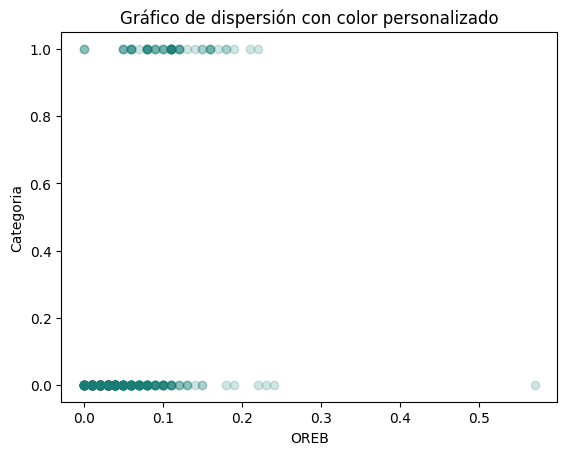

In [67]:
import matplotlib.pyplot as plt

plt.scatter(subset_datos5['OREB'], subset_datos5['Categoria'], alpha=0.2, c='#197D75')
plt.xlabel('OREB')  # Asegúrate de añadir etiquetas a los ejes
plt.ylabel('Categoria')
plt.title('Gráfico de dispersión con color personalizado')
plt.show()

In [68]:
X_data_5 = subset_datos5.iloc[:,:-1].values
Y_data_5 = subset_datos5.iloc[:,-1].values

X_data_5

array([[1.31, 0.  , 0.  , 0.  ],
       [1.02, 0.26, 0.08, 0.18],
       [0.9 , 0.2 , 0.02, 0.25],
       ...,
       [0.  , 0.23, 0.  , 0.14],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.17]])

In [69]:
#Escalamos atributos
scaler = StandardScaler()

scaler.fit(X_data_5)

X_scaled_5=scaler.transform(X_data_5)

In [70]:
X_train_5, X_test_5, Y_train_5, Y_test_5 = train_test_split(X_scaled_5, Y_data_5, test_size=0.2, random_state=23)
print("Tamaño dataset entrenamiento:",X_train_5.shape)
print("Tamaño dataset validación:",X_test_5.shape)

Tamaño dataset entrenamiento: (395, 4)
Tamaño dataset validación: (99, 4)


Accuracy: 0.89

Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94        86
           1       0.75      0.23      0.35        13

    accuracy                           0.89        99
   macro avg       0.82      0.61      0.65        99
weighted avg       0.88      0.89      0.86        99



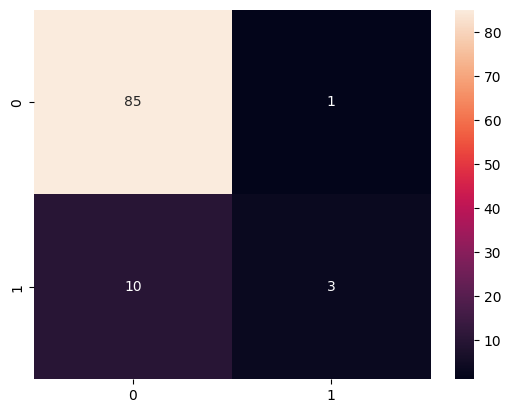

In [71]:
from sklearn.linear_model import LogisticRegression

# Initialize and train the logistic regression model
logistic = LogisticRegression(random_state=23)
logistic.fit(X_train_5, Y_train_5)

# Make predictions on the test set
logistic_prediction = logistic.predict(X_test_5)

# Evaluate the model
accuracy = accuracy_score(Y_test_5, logistic_prediction)
conf_matrix = confusion_matrix(Y_test_5, logistic_prediction)
classification_rep = classification_report(Y_test_5, logistic_prediction)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
sns.heatmap(conf_matrix, annot = True)
print("\nClassification Report:")
print(classification_rep)

Accuracy: 0.89

Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94        86
           1       0.75      0.23      0.35        13

    accuracy                           0.89        99
   macro avg       0.82      0.61      0.65        99
weighted avg       0.88      0.89      0.86        99



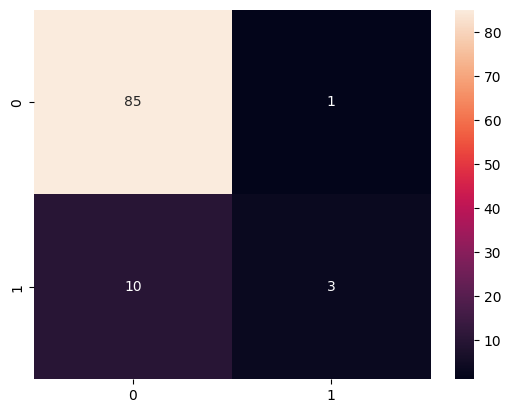

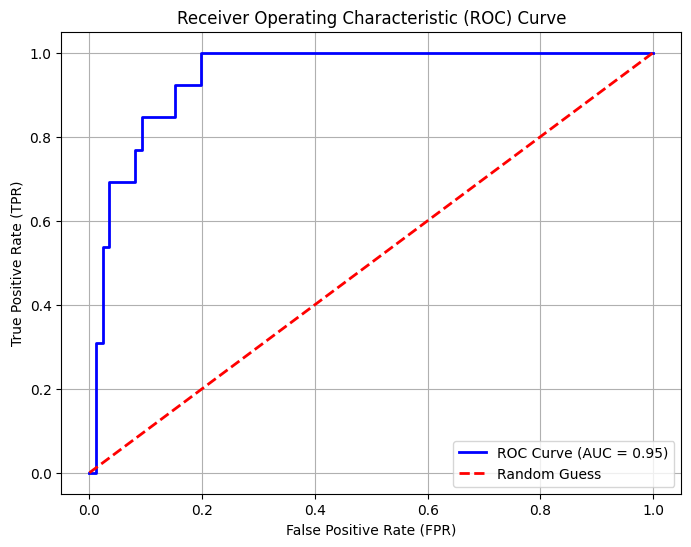

In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Inicializar y entrenar el modelo de regresión logística
logistic = LogisticRegression(random_state=23)
logistic.fit(X_train_5, Y_train_5)

# Realizar predicciones en el conjunto de prueba
logistic_prediction = logistic.predict(X_test_5)

# Evaluar el modelo
accuracy = accuracy_score(Y_test_5, logistic_prediction)
conf_matrix = confusion_matrix(Y_test_5, logistic_prediction)
classification_rep = classification_report(Y_test_5, logistic_prediction)

# Imprimir los resultados
print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
sns.heatmap(conf_matrix, annot=True)
print("\nClassification Report:")
print(classification_rep)

# Calcular la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(Y_test_5, logistic.decision_function(X_test_5))
auc = roc_auc_score(Y_test_5, logistic.decision_function(X_test_5))

# Plotear la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()


In [73]:
from sklearn.model_selection import cross_val_score

# Inicializar el modelo de regresión logística
logistic_model = LogisticRegression(random_state=23)

# Realizar validación cruzada estándar
cv_scores = cross_val_score(logistic_model, X_train_5, Y_train_5, cv=5)

# Imprimir los puntajes de validación cruzada estándar
print("Puntuaciones de validación cruzada estándar:", cv_scores)

# Imprimir la precisión media
print("Precisión media (estándar):", np.mean(cv_scores))


Puntuaciones de validación cruzada estándar: [0.88607595 0.89873418 0.89873418 0.89873418 0.88607595]
Precisión media (estándar): 0.8936708860759494


In [74]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Inicializar el modelo de regresión logística
logistic_model = LogisticRegression(random_state=23)

# Realizar validación cruzada estratificada
stratified_cv_scores = cross_val_score(logistic_model, X_train_5, Y_train_5, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=23))

# Imprimir los puntajes de validación cruzada estratificada
print("Puntuaciones de validación cruzada estratificada:", stratified_cv_scores)

# Imprimir la precisión media
print("Precisión media (estratificada):", np.mean(stratified_cv_scores))


Puntuaciones de validación cruzada estratificada: [0.88607595 0.88607595 0.88607595 0.92405063 0.87341772]
Precisión media (estratificada): 0.8911392405063291


En los resultados de la validación cruzada estándar y estratificada, se observa que ambas tienen puntajes de precisión bastante cercanos. Sin embargo, hay una pequeña diferencia. La validación cruzada estratificada tiene una precisión media ligeramente más alta en comparación con la validación cruzada estándar.

Exploramos tres métodos de aprendizaje supervisado para la clasificación: el Árbol de Decisión, el KNN y la Regresión Logística. Realizamos tareas de clasificación multiclase con los primeros dos y, finalmente, una clasificación binaria con el último. Para este trabajo lo primero que hemos hecho es reconstruir un dataframe en base a lo observado en el trabajo anterior, esperando obtener mejores resultados. Ademas, en cada uno de los modelos, realizamos la conversión de datos categóricos a numéricos, dividimos los conjuntos en atributos y etiquetas, normalizamos los datos para evitar inconvenientes con las escalas de las variables, entrenamos los modelos utilizando divisiones entre conjuntos de entrenamiento y prueba, optimizamos los hiperparámetros de cada modelo mediante Grid Search, y finalmente, validamos los resultados a través de dos enfoques de validación cruzada: uno estándar y otro estratificado. Este proceso garantiza una evaluación completa y robusta de nuestros modelos.n.Para el modelo de regresion logistica, hemos planteado una clasificacion binaria que divide el data set segun la media de edad de cada jugador.ria. Obtuvimos resultados prometedores, con una precisión 89l 95%. Además, visualizamos el rendimiento mediante el área bajo la curva ROC, confirmado la eficacia del modelo.

Luego de llevar a cabo las agrupaciones mediante distintos modelos, es fundamental resaltar varias consideraciones. En primer lugar, la importancia de emplear algoritmos que optimicen nuestros modelos. Grid Search ha demostrado proporcionar resultados superiores sin la necesidad de buscar manualmente los hiperparámetros que mejor se ajustan. Todos los modelos demandan un conocimiento general del dominio que se está analizando. Para lograr una eficiencia óptima en la predicción de categorías, es esencial evaluar estadísticamente qué variables podrían ofrecer una mayor separabilidad entre los diferentes grupos objetivo. Este enfoque robustecerá significativamente las implicancias predictivas de cada modelo, haciéndolos más sólidos y confiab

En conclusion, cada modelo se adapta mejor dependiendo las caracteristicas del data set y de lo que querramos investigar. Debemos ser concientes de que es sumamente importante tener un fuerte conocimiento del dominio, ya que de otro modo estariamos forzando al modelo a resultados poco robustos.les.